In [1]:
import numpy as np
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCABasis, FPCAGrid#, RegularizationParameterSearch, FPCARegularizationCVScorer
from skfda.representation import FDataBasis, FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.datasets._real_datasets import fetch_growth, fetch_weather, fetch_phoneme, fetch_medflies
from matplotlib import pyplot as plt
from matplotlib import pyplot
import matplotlib as mpl
from skfda.representation.basis import Fourier, BSpline, Monomial
from sklearn.decomposition import PCA

import skfda.preprocessing.smoothing.kernel_smoothers as ks
import skfda.preprocessing.smoothing.validation as val

def inner_product_regularized(first,
                              second,
                              derivative_degree,
                              regularization_parameter):
    return first.inner_product(second) + \
           regularization_parameter * \
           first.derivative(derivative_degree).\
           inner_product(second.derivative(derivative_degree))


In [4]:
# TODO, change this in feature/fpca
weather_fd = fetch_weather()['data']
temp_fd = weather_fd.coordinates[0]

In [4]:
fd_basis = FDataBasis(coefficients=[[1,2,3],[4,5,6]], basis=Fourier())

In [9]:
fd_basis[0]

FDataBasis(
    basis=Fourier(domain_range=[array([0, 1])], n_basis=3, period=1),
    coefficients=[[ 4  8 12]],
    dataset_label=None,
    axes_labels=None,
    extrapolation=None,
    keepdims=False)

In [2]:
mpl.rcParams['figure.figsize'] = [12, 8]

In [59]:
encontrar otro suavizado, en el pasado a bases?

pca discretizada para los datos
grafica sobre las lambdas de un componente
estudio de continuidad (mates)


SyntaxError: invalid syntax (<ipython-input-59-475e75d50a1c>, line 3)

In [2]:
def get_mean_functions(fd, names):
    means = []
    for i in range(len(names)):
        means.append(fd[y==i].mean())
        means[i].dataset_label = names[i]
    return means

In [3]:
def plot_grid(data_list, names, title, axes_labels=None, ylim=(0,25)):
    
    fig, axs = plt.subplots(3, 2, figsize=(14,14))
    data_list[0].plot(axs[0,0])
    axs[0,0].set_title(names[0])
    axs[0,0].set_ylim(ylim)
    data_list[1].plot(axs[0,1])
    axs[0,1].set_title(names[1])
    axs[0,1].set_ylim(ylim)
    data_list[2].plot(axs[1,0])
    axs[1,0].set_title(names[2])
    axs[1,0].set_ylim(ylim)
    data_list[3].plot(axs[1,1])
    axs[1,1].set_title(names[3])
    axs[1,1].set_ylim(ylim)
    data_list[4].plot(axs[2,0])
    axs[2,0].set_title(names[4])
    axs[2,0].set_ylim(ylim)
    
    if len(names) > 5:
        data_list[5].plot(axs[2,1])
        axs[2,1].set_title(names[5])
        axs[2,1].set_ylim(ylim)
        
    
    if axes_labels is not None:
        axs[0,0].set_xlabel(axes_labels[0])
        axs[0,0].set_ylabel(axes_labels[1])
        axs[0,1].set_xlabel(axes_labels[0])
        axs[0,1].set_ylabel(axes_labels[1])
        axs[1,0].set_xlabel(axes_labels[0])
        axs[1,0].set_ylabel(axes_labels[1])
        axs[1,1].set_xlabel(axes_labels[0])
        axs[1,1].set_ylabel(axes_labels[1])
        axs[2,0].set_xlabel(axes_labels[0])
        axs[2,0].set_ylabel(axes_labels[1])
        axs[2,1].set_xlabel(axes_labels[0])
        axs[2,1].set_ylabel(axes_labels[1])
    
    plt.suptitle(title)
    plt.show()

In [4]:
def transform_basis_range(data):
    data_list = []
    for i in range(len(data)):
        new_basis = data[i].basis.copy()
        new_basis.knots = np.array(new_basis.knots)
        new_basis.knots *= (8000/255)
        data_list.append(data[i].copy(basis=new_basis))
    return data_list

In [5]:
def transform_grid_range(data):
    data_list = []
    for i in range(len(data)):
        data_list.append(data[i].copy(sample_points=np.array(data[i].sample_points)*8000/255))
        
    return data_list

In [6]:
def plot_same_fig(data_list, names, length, title, axes_labels = None):
    fig = plt.figure(figsize=(14,8))
    for i in range(length):
        data_list[i].plot(fig, label=names[i])
    fig.legend()
    plt.suptitle(title)
    if axes_labels is not None:
        plt.xlabel(axes_labels[0])
        plt.ylabel(axes_labels[1])
    plt.show()

In [7]:
def get_first_component(fd_basis, reg_param=0, derivative_degree=2):
    fpca_basis = FPCABasis(n_components=1, 
                           regularization_parameter = reg_param,
                           regularization_lfd=derivative_degree)
    fpca_basis.fit(fd_basis.copy(coefficients=fd_basis.coefficients.copy()))
    return fpca_basis.components_

In [8]:
def get_three_components(fd_basis, reg_param=0, derivative_degree=2):
    fpca_basis = FPCABasis(n_components=3, 
                           regularization_parameter = reg_param,
                           regularization_lfd=derivative_degree)
    fpca_basis.fit(fd_basis.copy(coefficients=fd_basis.coefficients.copy()))
    return fpca_basis.components_

In [9]:
import pickle
def save_components(components, file_name):
    with open(file_name, 'wb') as f:
        # Step 3
        pickle.dump(components, f)

In [10]:
def get_smoothed_dataset(fd, smoothing_parameter=0):
    smoother = BasisSmoother(basis=BSpline(n_basis=55, domain_range=fd.domain_range), 
                             return_basis=True,
                             smoothing_parameter=smoothing_parameter,
                             penalty=2)
    fd_basis = smoother.fit_transform(fd)
    fd_basis.axes_labels = fd.axes_labels
    return fd_basis

# Phonemes Study

In [11]:
phonemes = fetch_phoneme()
y = phonemes['target']
fd = phonemes['data']
names = phonemes['target_names']

In [12]:
fd_basis=phonemes['data'].to_basis(BSpline(n_basis=55))
first_component_basis = get_first_component(fd_basis)

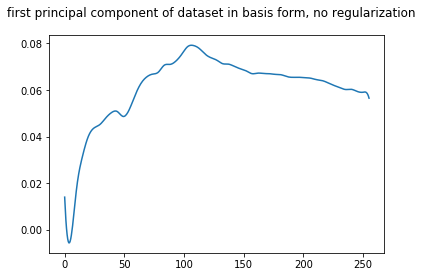

In [13]:
first_component_basis.dataset_label='first principal component of dataset in basis form, no regularization'
first_component_basis.plot()
pyplot.show()

In [ ]:
fd = FDataGrid(data_matrix=np.squeeze(fd.data_matrix),
                   sample_points=np.array(range(0, 256))*8000/255,
                   dataset_label="Phoneme",
                   axes_labels=["frequency", "log-periodogram"])

In [13]:
fd

FDataGrid(
    array([[[ 9.8577 ],
            [ 9.20711],
            [ 9.81689],
            ...,
            [12.92489],
            [12.51195],
            [ 9.75527]],
    
           [[13.23079],
            [14.19189],
            [15.34428],
            ...,
            [ 5.38504],
            [ 9.43063],
            [ 8.59328]],
    
           [[10.81889],
            [ 9.07615],
            [ 9.7794 ],
            ...,
            [ 6.58416],
            [ 6.27058],
            [ 3.85042]],
    
           ...,
    
           [[12.30174],
            [12.40383],
            [ 9.06497],
            ...,
            [ 9.88007],
            [10.82203],
            [12.00199]],
    
           [[ 8.39388],
            [ 9.8477 ],
            [16.24534],
            ...,
            [ 9.37979],
            [ 6.83916],
            [ 8.54817]],
    
           [[ 8.14032],
            [ 9.93753],
            [16.30187],
            ...,
            [ 7.08945],
            [ 7.7292

In [8]:
print(phonemes['DESCR'])


    These data arose from a collaboration between  Andreas Buja, Werner
    Stuetzle and Martin Maechler, and it is used as an illustration in the
    paper on Penalized Discriminant Analysis by Hastie, Buja and
    Tibshirani (1995).

    The data were extracted from the TIMIT database (TIMIT
    Acoustic-Phonetic Continuous Speech Corpus, NTIS, US Dept of Commerce)
    which is a widely used resource for research in speech recognition.  A
    dataset was formed by selecting five phonemes for
    classification based on digitized speech from this database.  The
    phonemes are transcribed as follows: "sh" as in "she", "dcl" as in
    "dark", "iy" as the vowel in "she", "aa" as the vowel in "dark", and
    "ao" as the first vowel in "water".  From continuous speech of 50 male
    speakers, 4509 speech frames of 32 msec duration were selected,
    approximately 2 examples of each phoneme from each speaker.  Each
    speech frame is represented by 512 samples at a 16kHz sampling rate,


"sh" as in "she" <br>
"dcl" as in "dark" <br>
"iy" as the vowel in "she" <br>
"aa" as the vowel in "dark"<br>
"ao" as the first vowel in "water".<br>

In [76]:
#smoother = BasisSmoother(BSpline(n_basis=30), smoothing_parameter=0, penalty=2, return_basis=True)

## convert to basis using basis smoother with no extra smoothing via penalty

In [12]:
smoother = BasisSmoother(basis=BSpline(n_basis=55, domain_range=fd.domain_range), return_basis=True)
fd_basis = smoother.fit_transform(fd)
fd_basis.axes_labels = fd.axes_labels
basis_means = get_mean_functions(fd_basis, names)
basis_means.append(fd_basis.mean())

In [45]:
fd_basis

FDataBasis(
    basis=BSpline(domain_range=[array([  0, 255])], n_basis=55, order=4, knots=[0.0, 4.903846153846154, 9.807692307692308, 14.711538461538463, 19.615384615384617, 24.51923076923077, 29.423076923076927, 34.32692307692308, 39.23076923076923, 44.13461538461539, 49.03846153846154, 53.94230769230769, 58.846153846153854, 63.75000000000001, 68.65384615384616, 73.5576923076923, 78.46153846153847, 83.36538461538463, 88.26923076923077, 93.17307692307693, 98.07692307692308, 102.98076923076924, 107.88461538461539, 112.78846153846155, 117.69230769230771, 122.59615384615385, 127.50000000000001, 132.40384615384616, 137.30769230769232, 142.21153846153848, 147.1153846153846, 152.01923076923077, 156.92307692307693, 161.8269230769231, 166.73076923076925, 171.6346153846154, 176.53846153846155, 181.4423076923077, 186.34615384615387, 191.25, 196.15384615384616, 201.05769230769232, 205.96153846153848, 210.86538461538464, 215.76923076923077, 220.67307692307693, 225.5769230769231, 230.4807692307692

In [85]:
fd[-1:].data_matrix

array([[[ 8.14032],
        [ 9.93753],
        [16.30187],
        [17.31425],
        [14.40116],
        [13.52353],
        [16.85938],
        [17.14016],
        [13.06426],
        [15.3222 ],
        [18.03233],
        [17.47334],
        [11.03053],
        [17.08843],
        [18.93884],
        [17.44032],
        [12.99993],
        [18.73487],
        [19.79776],
        [17.46989],
        [15.68381],
        [19.3275 ],
        [19.58592],
        [15.26242],
        [14.84805],
        [17.97818],
        [18.12439],
        [15.38595],
        [16.27315],
        [17.57432],
        [16.6368 ],
        [13.4872 ],
        [17.01031],
        [17.42739],
        [15.80666],
        [13.45408],
        [14.50518],
        [14.82482],
        [13.5724 ],
        [12.03891],
        [12.97758],
        [12.96006],
        [10.85731],
        [ 7.15824],
        [12.46416],
        [11.0471 ],
        [10.14107],
        [ 7.90453],
        [11.29681],
        [ 9.04112],


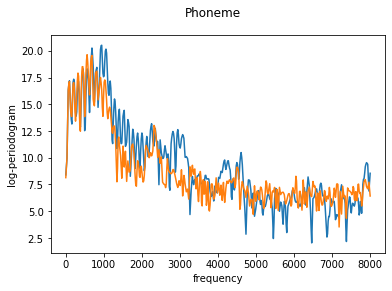

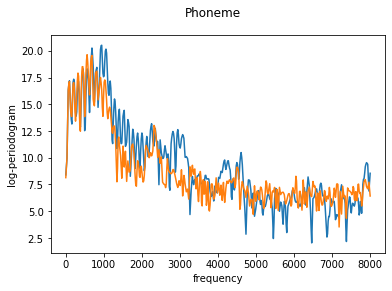

In [86]:
fd[-2:].plot()

In [98]:
print(fd[y==0].n_samples)

695


In [105]:
for i in range (15):
    print(str(i) + ' ' + str(sum(np.squeeze(fd[y==0].data_matrix[:,-1:]) < i)))

0 5
1 9
2 13
3 27
4 37
5 68
6 112
7 194
8 270
9 391
10 504
11 598
12 659
13 682
14 690


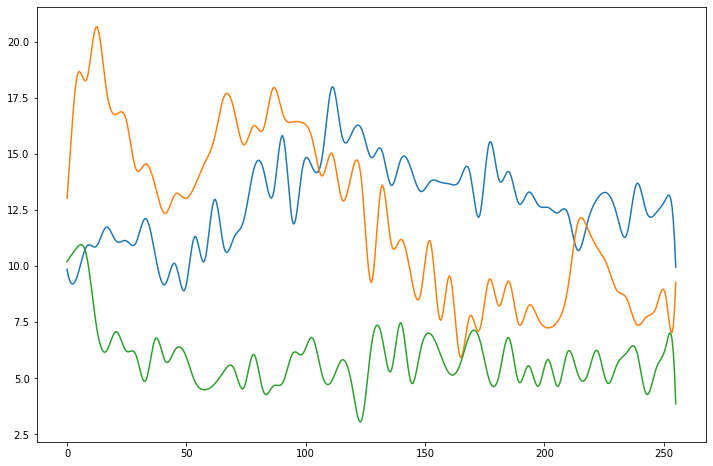

In [106]:
fd_basis[:3].plot()
pyplot.show()

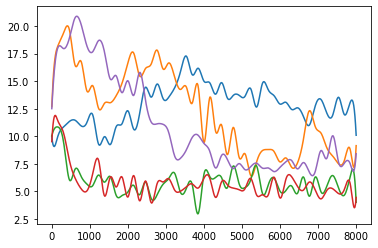

In [72]:
fig = plt.figure()
fd_basis[:5].plot(fig=fig)
pyplot.show()

### mean functions in both dicretized and basis representation, for each phoneme

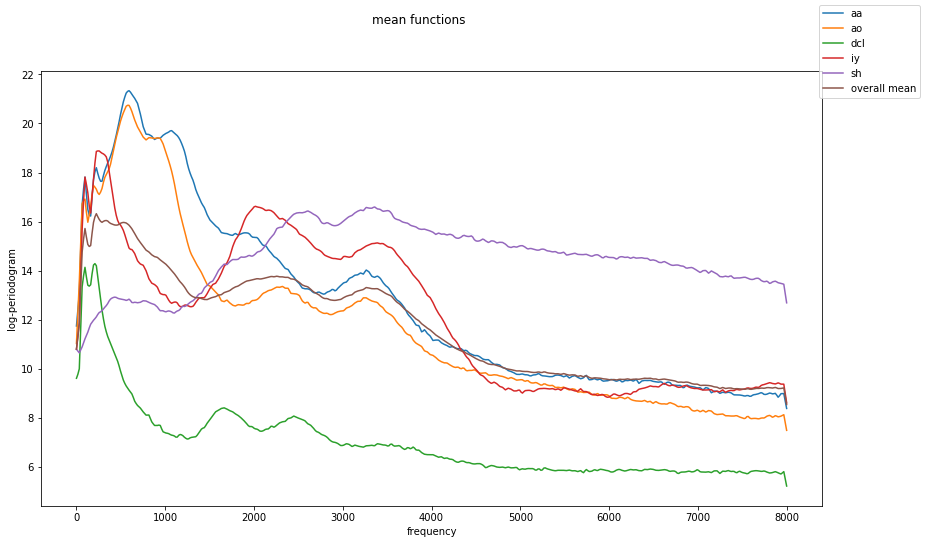

In [15]:
means = get_mean_functions(fd, names)
means.append(fd.mean())
plot_same_fig(means, names + ['overall mean'], 6, 'mean functions')

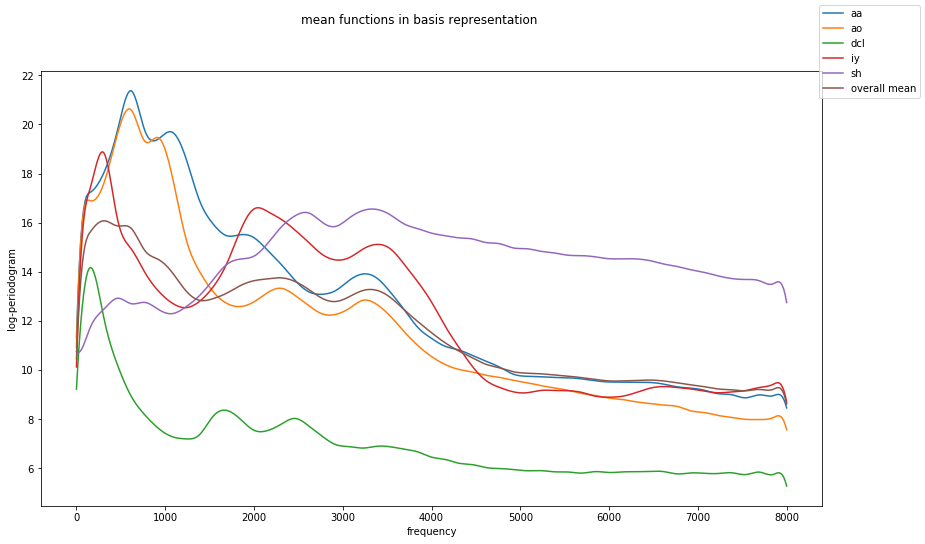

In [16]:
plot_same_fig(basis_means, names + ['overall mean'], 
              6, 'mean functions in basis representation', fd.axes_labels)

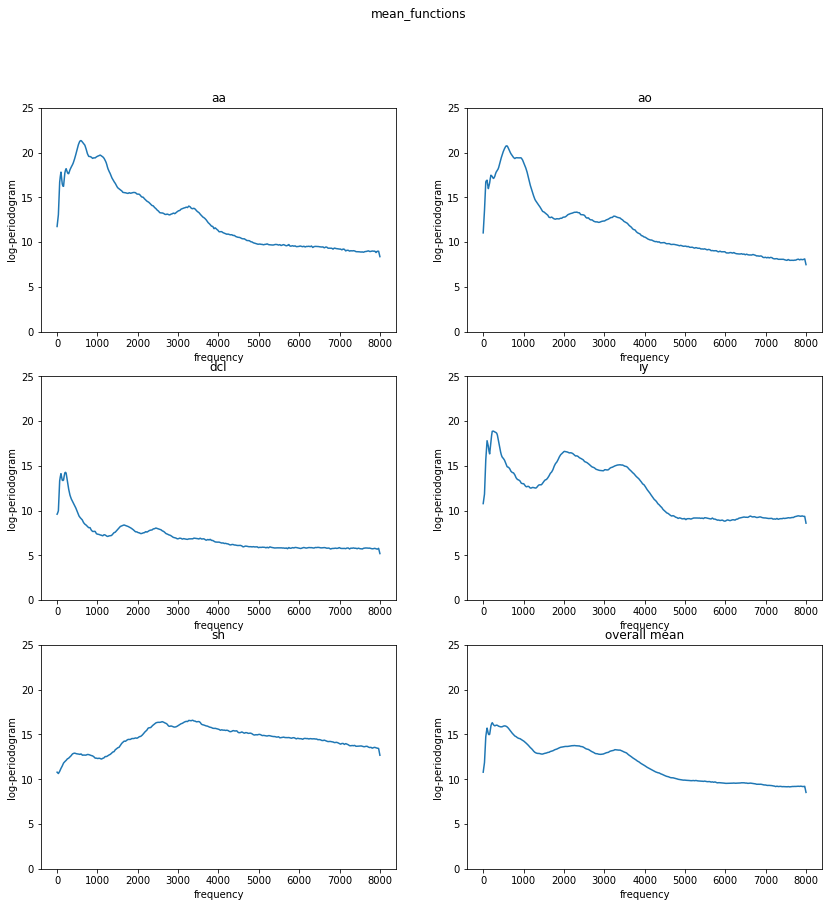

In [17]:
plot_grid(means, names + ['overall mean'], 'mean_functions')

In [154]:
[1,2] + [3]

[1, 2, 3]

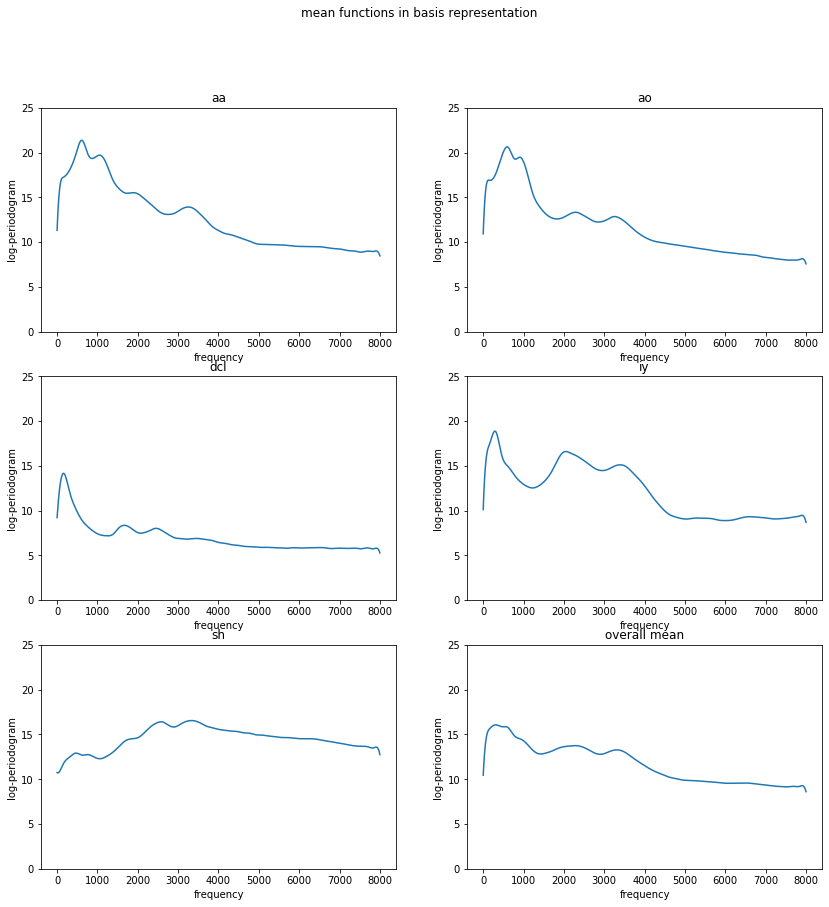

In [26]:
plot_grid(basis_means, 
          names + ['overall mean'], 
          'mean functions in basis representation',
          axes_labels = fd.axes_labels)

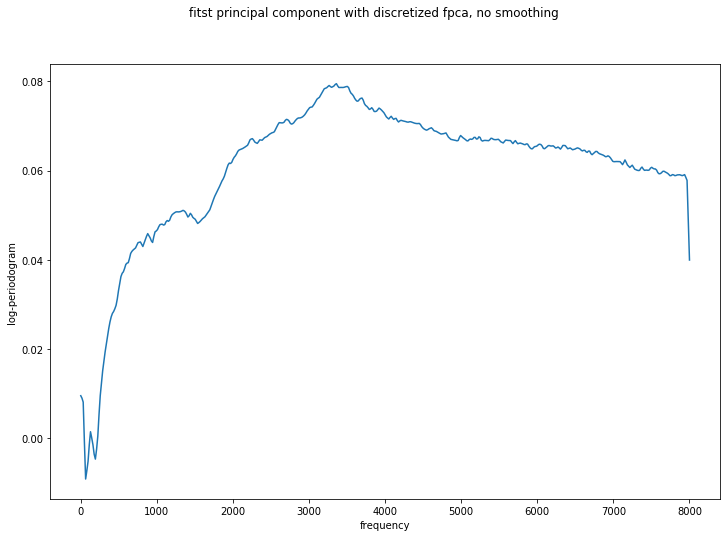

In [47]:
fpca_discretized = FPCAGrid(n_components=1)
fpca_discretized.fit(fd.copy(data_matrix=fd.data_matrix.copy()))
fpca_discretized.components_.dataset_label = 'fitst principal component with discretized fpca, no smoothing'
fpca_discretized.components_.plot()
pyplot.show()

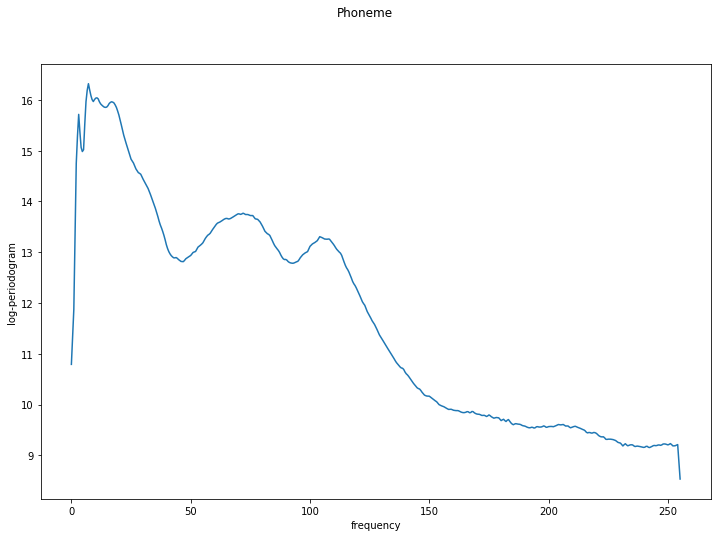

In [142]:
fd.mean().plot()
pyplot.show()

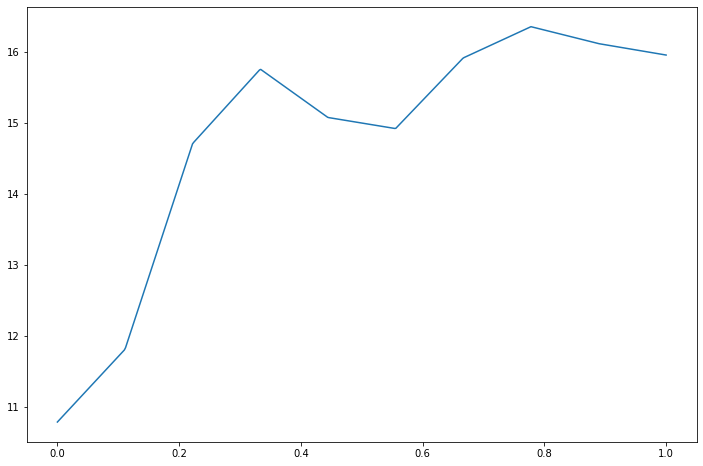

In [140]:
temporal = FDataGrid(data_matrix=np.squeeze(fd.mean()[:, 0:10].data_matrix))
temporal.plot()
pyplot.show()

In [34]:
np.array(fd_basis.basis.knots) / 8000 * 256

array([  0.        ,   4.92307692,   9.84615385,  14.76923077,
        19.69230769,  24.61538462,  29.53846154,  34.46153846,
        39.38461538,  44.30769231,  49.23076923,  54.15384615,
        59.07692308,  64.        ,  68.92307692,  73.84615385,
        78.76923077,  83.69230769,  88.61538462,  93.53846154,
        98.46153846, 103.38461538, 108.30769231, 113.23076923,
       118.15384615, 123.07692308, 128.        , 132.92307692,
       137.84615385, 142.76923077, 147.69230769, 152.61538462,
       157.53846154, 162.46153846, 167.38461538, 172.30769231,
       177.23076923, 182.15384615, 187.07692308, 192.        ,
       196.92307692, 201.84615385, 206.76923077, 211.69230769,
       216.61538462, 221.53846154, 226.46153846, 231.38461538,
       236.30769231, 241.23076923, 246.15384615, 251.07692308,
       256.        ])

In [32]:
fd_basis

FDataBasis(
    basis=BSpline(domain_range=[array([   0., 8000.])], n_basis=55, order=4, knots=[0.0, 153.84615384615384, 307.6923076923077, 461.53846153846155, 615.3846153846154, 769.2307692307692, 923.0769230769231, 1076.923076923077, 1230.7692307692307, 1384.6153846153845, 1538.4615384615383, 1692.3076923076922, 1846.1538461538462, 2000.0, 2153.846153846154, 2307.6923076923076, 2461.5384615384614, 2615.3846153846152, 2769.230769230769, 2923.076923076923, 3076.9230769230767, 3230.7692307692305, 3384.6153846153843, 3538.461538461538, 3692.3076923076924, 3846.153846153846, 4000.0, 4153.846153846153, 4307.692307692308, 4461.538461538461, 4615.384615384615, 4769.230769230769, 4923.076923076923, 5076.923076923077, 5230.7692307692305, 5384.615384615385, 5538.461538461538, 5692.307692307692, 5846.153846153846, 6000.0, 6153.846153846153, 6307.692307692308, 6461.538461538461, 6615.384615384615, 6769.230769230769, 6923.076923076923, 7076.923076923076, 7230.7692307692305, 7384.615384615385, 7538

In [37]:
BSpline(n_basis=55, domain_range=[0,8000]).penalty(0)

array([[21.97802198, 13.46153846,  2.83882784, ...,  0.        ,
         0.        ,  0.        ],
       [13.46153846, 34.06593407, 24.03846154, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.83882784, 24.03846154, 50.27472527, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 50.27472527,
        24.03846154,  2.83882784],
       [ 0.        ,  0.        ,  0.        , ..., 24.03846154,
        34.06593407, 13.46153846],
       [ 0.        ,  0.        ,  0.        , ...,  2.83882784,
        13.46153846, 21.97802198]])

In [39]:
BSpline(n_basis=55, domain_range=[0,255]).penalty(0) * 8000 / 255

array([[21.97802198, 13.46153846,  2.83882784, ...,  0.        ,
         0.        ,  0.        ],
       [13.46153846, 34.06593407, 24.03846154, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.83882784, 24.03846154, 50.27472527, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 50.27472527,
        24.03846154,  2.83882784],
       [ 0.        ,  0.        ,  0.        , ..., 24.03846154,
        34.06593407, 13.46153846],
       [ 0.        ,  0.        ,  0.        , ...,  2.83882784,
        13.46153846, 21.97802198]])

In [13]:
def get_first_component(fd_basis, reg_param=0, derivative_degree=2):
    fpca_basis = FPCABasis(n_components=1, 
                           regularization_parameter = reg_param,
                           regularization_lfd=derivative_degree)
    fpca_basis.fit(fd_basis.copy(coefficients=fd_basis.coefficients.copy()))
    return fpca_basis.components_

In [12]:
fd_basis=phonemes['data'].to_basis(BSpline(n_basis=55))
first_component_basis = get_first_component(fd_basis)

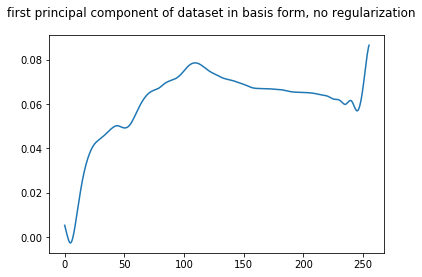

In [13]:
first_component_basis.dataset_label='first principal component of dataset in basis form, no regularization'
first_component_basis.plot()
pyplot.show()

 what does this principal component mean???


In [15]:
def stack_component(data, component):
    mean_fd = data.mean()
    mean_fd.coefficients = np.vstack([mean_fd.coefficients,
                                      mean_fd.coefficients[0, :] +
                                      20 * component.coefficients[0, :]])
    mean_fd.coefficients = np.vstack([mean_fd.coefficients,
                                      mean_fd.coefficients[0, :] -
                                      20 * component.coefficients[0, :]])
    return mean_fd

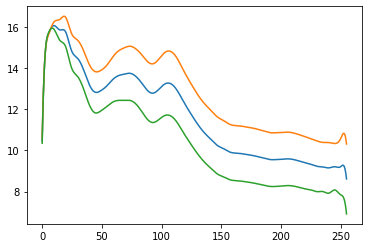

In [16]:
mean_fd = fd_basis.mean()
mean_fd.coefficients = np.vstack([mean_fd.coefficients,
                                  mean_fd.coefficients[0, :] +
                                  20 * first_component_basis.coefficients[0, :]])
mean_fd.coefficients = np.vstack([mean_fd.coefficients,
                                  mean_fd.coefficients[0, :] -
                                  20 * first_component_basis.coefficients[0, :]])
mean_fd.plot()
pyplot.show()

In [28]:
params = [(10)**i for i in range(6)]
params_names = ['lambda=' + str(i) for i in params]

In [77]:
params_names

['lambda=1',
 'lambda=10',
 'lambda=100',
 'lambda=1000',
 'lambda=10000',
 'lambda=100000']

In [82]:
components_regularization = []
for i in range(len(params)):
    components_regularization.append(get_three_components(reg_param=params[i]))


NameError: name 'component' is not defined

In [84]:
save_components(components_regularization, 'components_regularization.data')

In [86]:
first_components=[component[0] for component in components_regularization]

In [33]:
# Step 2
with open('first_component_regularized.data', 'wb') as first_component_regularized_file:
  # Step 3
  pickle.dump(first_components, first_component_regularized_file)

In [34]:
 
# Step 2
with open('first_component_regularized.data', 'rb') as first_component_regularized_file:
 
    # Step 3
    first_components_regularized = pickle.load(first_component_regularized_file)
 
    # After config_dictionary is read from file
    print(first_components_regularized)

[FDataBasis(
    basis=BSpline(domain_range=[array([  0, 255])], n_basis=50, order=4, knots=[0.0, 5.425531914893617, 10.851063829787234, 16.27659574468085, 21.70212765957447, 27.127659574468087, 32.5531914893617, 37.97872340425532, 43.40425531914894, 48.829787234042556, 54.255319148936174, 59.68085106382979, 65.1063829787234, 70.53191489361703, 75.95744680851064, 81.38297872340426, 86.80851063829788, 92.23404255319149, 97.65957446808511, 103.08510638297872, 108.51063829787235, 113.93617021276596, 119.36170212765958, 124.7872340425532, 130.2127659574468, 135.63829787234042, 141.06382978723406, 146.48936170212767, 151.91489361702128, 157.3404255319149, 162.76595744680853, 168.19148936170214, 173.61702127659575, 179.04255319148936, 184.46808510638297, 189.8936170212766, 195.31914893617022, 200.74468085106383, 206.17021276595744, 211.59574468085108, 217.0212765957447, 222.4468085106383, 227.87234042553192, 233.29787234042553, 238.72340425531917, 244.14893617021278, 249.5744680851064, 255.0

In [87]:
first_components_regularized=first_components

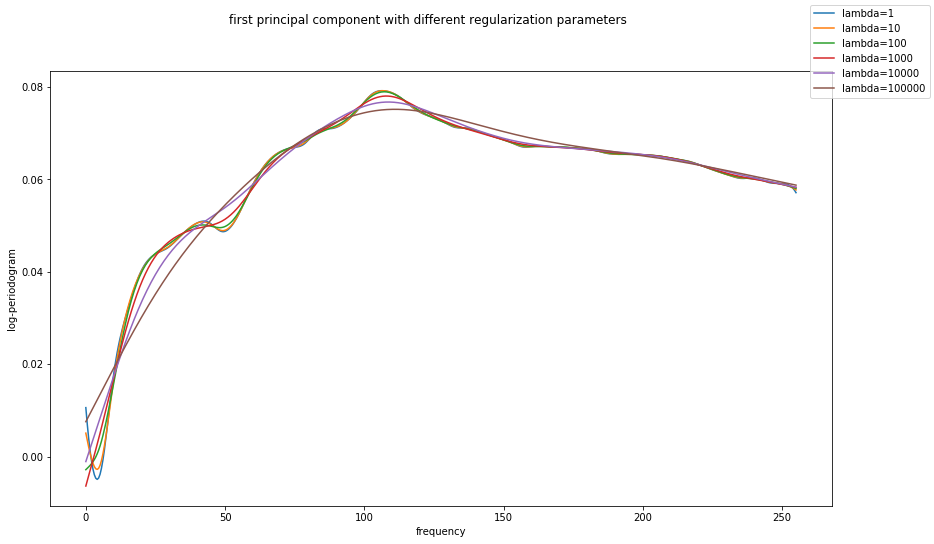

In [88]:
plot_same_fig(first_components_regularized,
              params_names,
              6,
              'first principal component with different regularization parameters',
              fd.axes_labels
              )

In [89]:
len(params_names)

6

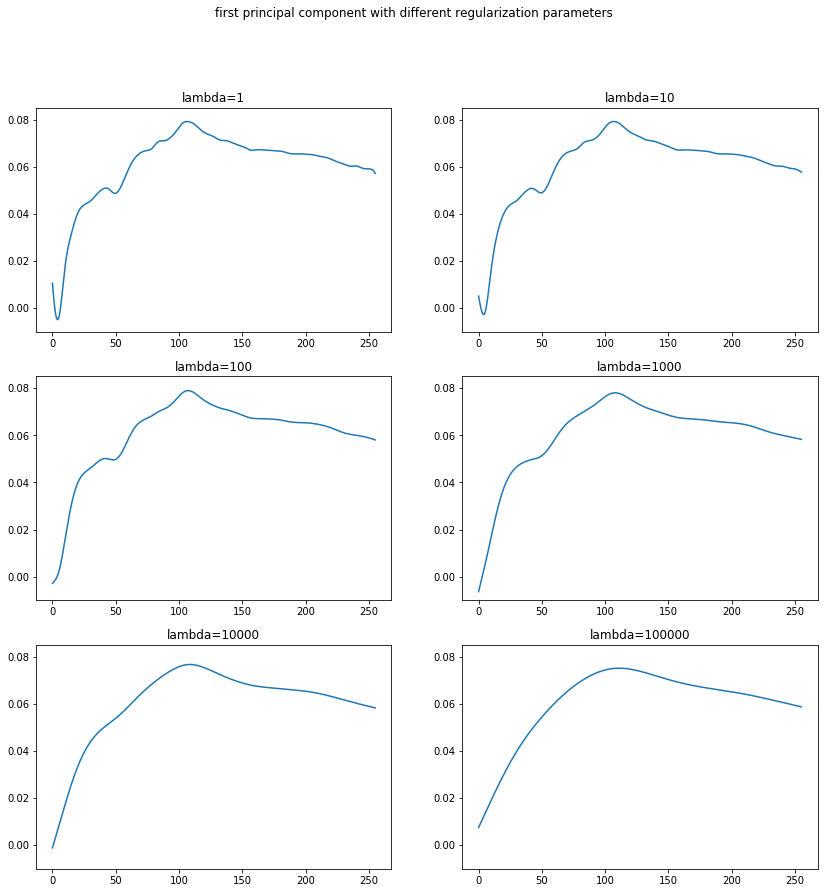

In [90]:
plot_grid(first_components_regularized, params_names, 
          'first principal component with different regularization parameters',
          ylim=(-0.01, 0.085))

In [94]:
first_components_stacked = [
    stack_component(fd_basis, first_components[i]) for i in range(len(first_components))
]

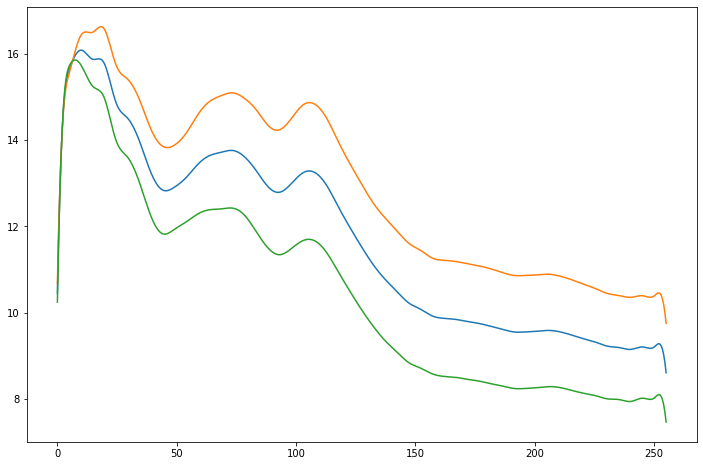

In [96]:
stack_component(fd_basis, first_components[0]).plot()
pyplot.show()

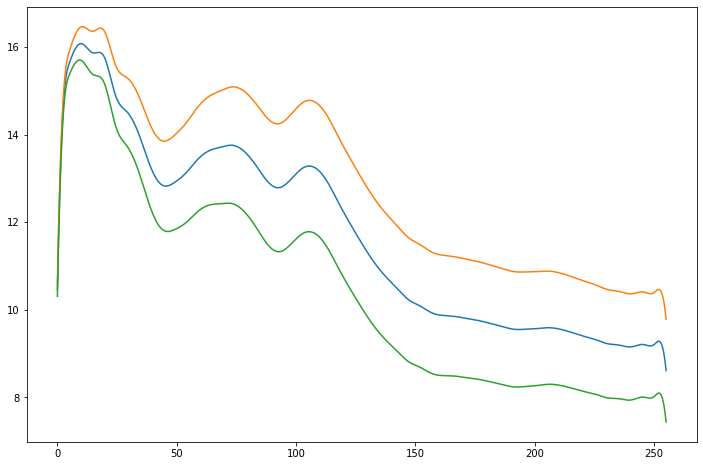

In [95]:
stack_component(fd_basis, first_components[5]).plot()
pyplot.show()

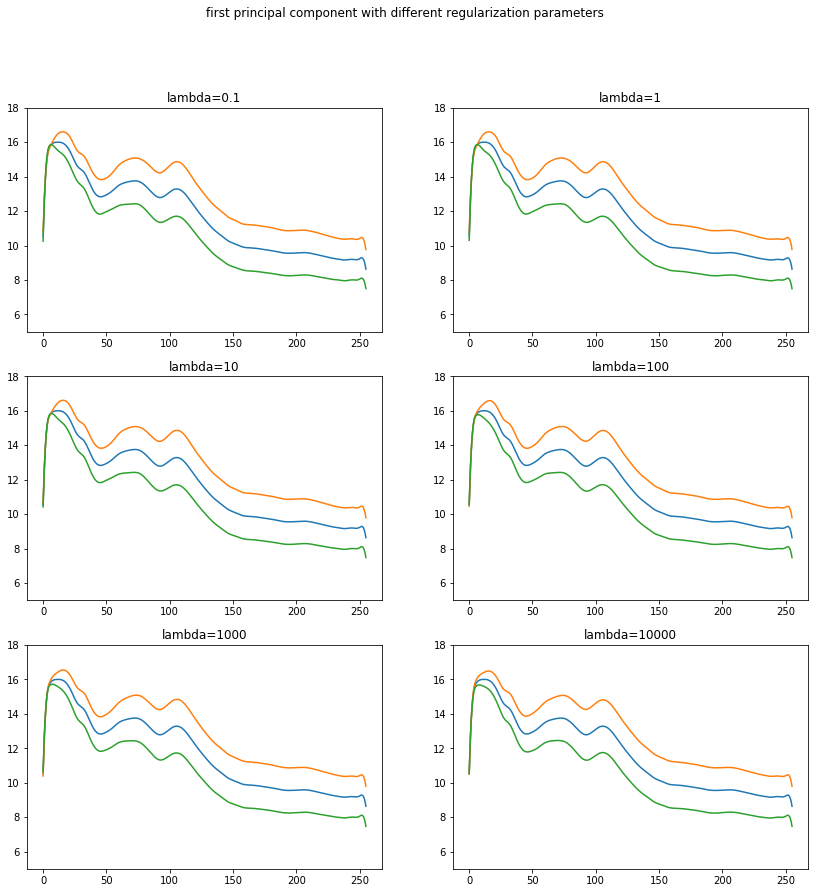

In [82]:
plot_grid(first_components_stacked, params_names, 
          'first principal component with different regularization parameters',
          ylim=(5,18))

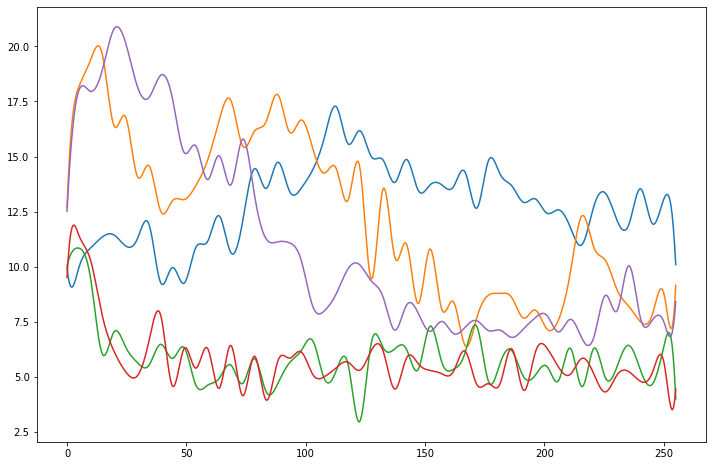

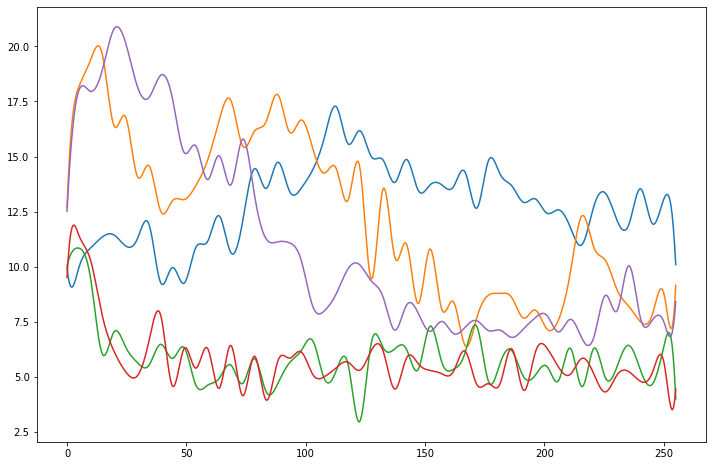

In [62]:
fd_basis[:5].plot()

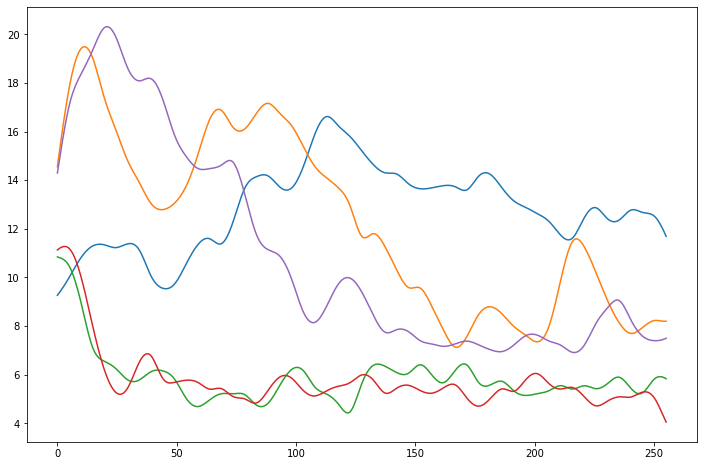

In [64]:
get_smoothed_dataset(100)[:5].plot()
pyplot.show()

## smoothe the dataset and then perform fpca

In [42]:
fd

FDataGrid(
    array([[[ 9.8577 ],
            [ 9.20711],
            [ 9.81689],
            ...,
            [12.92489],
            [12.51195],
            [ 9.75527]],
    
           [[13.23079],
            [14.19189],
            [15.34428],
            ...,
            [ 5.38504],
            [ 9.43063],
            [ 8.59328]],
    
           [[10.81889],
            [ 9.07615],
            [ 9.7794 ],
            ...,
            [ 6.58416],
            [ 6.27058],
            [ 3.85042]],
    
           ...,
    
           [[12.30174],
            [12.40383],
            [ 9.06497],
            ...,
            [ 9.88007],
            [10.82203],
            [12.00199]],
    
           [[ 8.39388],
            [ 9.8477 ],
            [16.24534],
            ...,
            [ 9.37979],
            [ 6.83916],
            [ 8.54817]],
    
           [[ 8.14032],
            [ 9.93753],
            [16.30187],
            ...,
            [ 7.08945],
            [ 7.7292

In [64]:

smoother = BasisSmoother(basis=BSpline(n_basis=55, domain_range=fd.domain_range), 
                             return_basis=True,
                             smoothing_parameter=1000000,
                             penalty=2)
fd_smoothed = smoother.fit_transform(fd)
fd_smoothed.axes_labels = fd.axes_labels

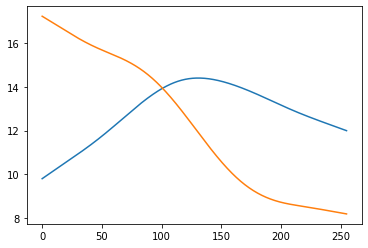

In [65]:
fd_smoothed[:2].plot()
pyplot.show()

In [61]:
smoothed_datasets = []
for i in range(len(params)):
    smoothed_datasets.append(get_smoothed_dataset(fd, smoothing_parameter=params[i]))

In [62]:
components_smoothed_datasets = [
    get_three_components(dataset) for dataset in smoothed_datasets
]
save_components(components_smoothed_datasets, 'components_smoothed_datasets.data')

In [66]:
first_components_smoothed_datasets = [
    component[0] for component in components_smoothed_datasets 
]

In [181]:
Monomial(n_basis=5).penalty(0)

array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.33333333, 0.25      , 0.2       , 0.16666667, 0.14285714],
       [0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ],
       [0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111]])

In [37]:
BSpline(n_basis=5).penalty(2)

array([[  96., -132.,   24.,   12.,    0.],
       [-132.,  192.,  -48.,  -24.,   12.],
       [  24.,  -48.,   48.,  -48.,   24.],
       [  12.,  -24.,  -48.,  192., -132.],
       [   0.,   12.,   24., -132.,   96.]])

In [178]:
BSpline(n_basis=5).penalty(0)

array([[0.07142857, 0.04375   , 0.00892857, 0.00089286, 0.        ],
       [0.04375   , 0.11071429, 0.06964286, 0.025     , 0.00089286],
       [0.00892857, 0.06964286, 0.09285714, 0.06964286, 0.00892857],
       [0.00089286, 0.025     , 0.06964286, 0.11071429, 0.04375   ],
       [0.        , 0.00089286, 0.00892857, 0.04375   , 0.07142857]])

In [175]:
Fourier(n_basis=3).penalty(0)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [176]:
Fourier(n_basis=3).gram_matrix()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

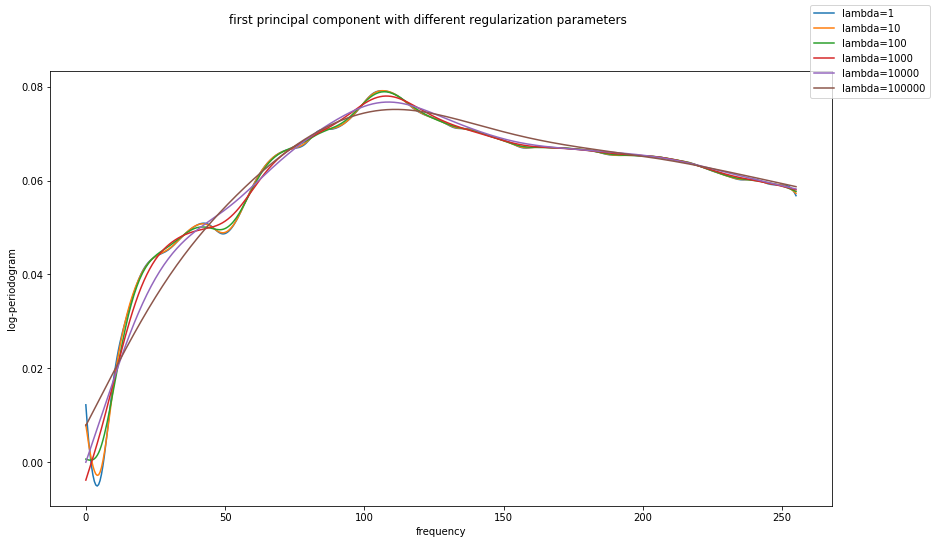

In [101]:
plot_same_fig(first_components_smoothed_datasets,
              params_names,
              6,
              'first principal component with different smoothing parameters',
              fd.axes_labels
              )

In [89]:
len(params_names)

6

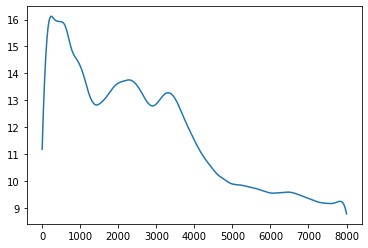

In [45]:
smoothed_datasets[5].mean().plot()
pyplot.show()

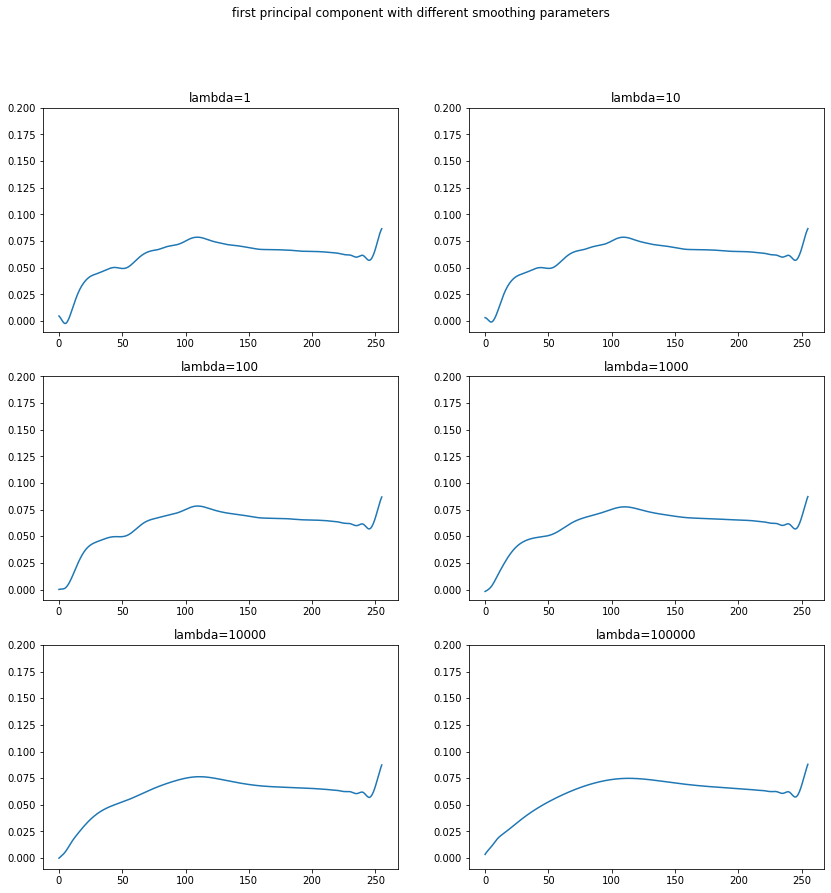

In [68]:
plot_grid(first_components_smoothed_datasets, params_names, 
          'first principal component with different smoothing parameters',
          ylim=(-0.01, 0.2))

In [103]:
first_components_smoothed_datasets[5].coefficients

array([[0.00779407, 0.00967438, 0.01343674, 0.01906983, 0.02458301,
        0.02984612, 0.03476359, 0.0392893 , 0.04342209, 0.04718818,
        0.05063318, 0.05381667, 0.05679517, 0.05959469, 0.06220948,
        0.06462181, 0.06681676, 0.06878539, 0.07051891, 0.07200397,
        0.07322835, 0.07417587, 0.07482634, 0.07516735, 0.07520857,
        0.07498357, 0.07454201, 0.07393781, 0.07322298, 0.07244484,
        0.0716423 , 0.07084851, 0.07009027, 0.06938681, 0.06874858,
        0.06817502, 0.06765894, 0.06718949, 0.06675416, 0.06634034,
        0.06593632, 0.06552945, 0.06510658, 0.06465653, 0.06417173,
        0.06364941, 0.06309112, 0.06250297, 0.06189348, 0.06127069,
        0.06063993, 0.06000335, 0.0593633 , 0.05893526, 0.05872123]])

In [69]:
first_components_smoothed_datasets[5].coefficients

array([[0.00350948, 0.00660068, 0.01008284, 0.01910757, 0.02301838,
        0.02771811, 0.03253201, 0.0371359 , 0.04140553, 0.04531645,
        0.0488922 , 0.05218147, 0.0552403 , 0.05810754, 0.06079231,
        0.06328357, 0.06556593, 0.06762799, 0.06946075, 0.07105284,
        0.07239172, 0.0734628 , 0.07424768, 0.07473075, 0.07491185,
        0.07481332, 0.07447675, 0.07395334, 0.07329554, 0.07255248,
        0.07176672, 0.07097395, 0.070204  , 0.06947918, 0.06881469,
        0.06821376, 0.06767503, 0.067185  , 0.06674065, 0.06631364,
        0.06592168, 0.06549701, 0.06513053, 0.06461648, 0.06430769,
        0.06352284, 0.06352484, 0.06195742, 0.06323503, 0.05914827,
        0.06492391, 0.05320222, 0.06640617, 0.08335983, 0.08806734]])

In [104]:
first_components_regularized[5].coefficients

array([[0.00753115, 0.00943318, 0.01323887, 0.01893259, 0.02449946,
        0.0298076 , 0.03476088, 0.03931318, 0.04346403, 0.04724057,
        0.05068972, 0.05387238, 0.05684638, 0.05963885, 0.06224499,
        0.06464784, 0.06683308, 0.06879225, 0.07051681, 0.07199353,
        0.0732101 , 0.07415015, 0.07479327, 0.07512686, 0.07516052,
        0.07492779, 0.07447844, 0.07386652, 0.07314427, 0.07235918,
        0.07155037, 0.07075116, 0.06998845, 0.06928152, 0.06864082,
        0.06806578, 0.06754915, 0.06707999, 0.06664571, 0.06623361,
        0.06583188, 0.06542785, 0.06500835, 0.06456223, 0.064082  ,
        0.06356504, 0.06301309, 0.06243246, 0.06183191, 0.06121969,
        0.06060124, 0.05997868, 0.05935415, 0.05893713, 0.05872862]])

In [188]:
def plot_means_with_overall(fd, names):
    means = get_mean_functions(fd, names)
    means.append(fd.mean())
    plot_same_fig(means, names + ['overall mean'], 6, 'mean functions')

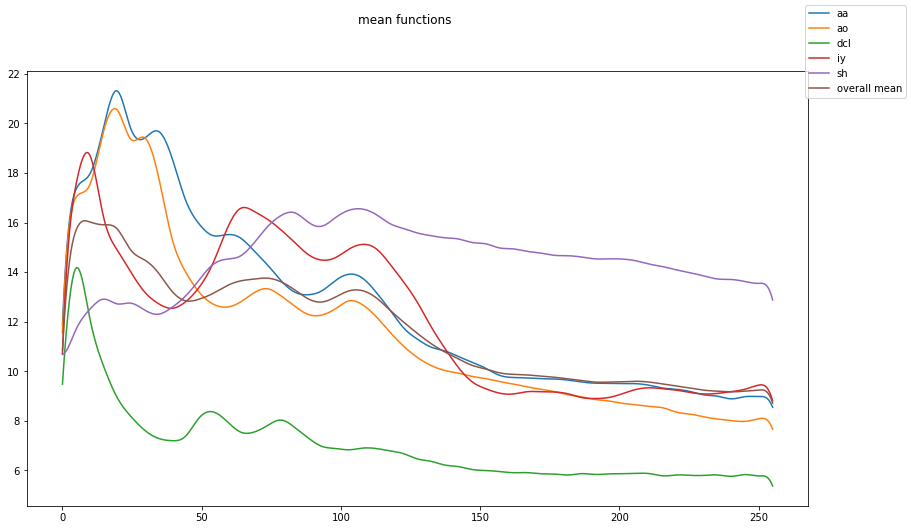

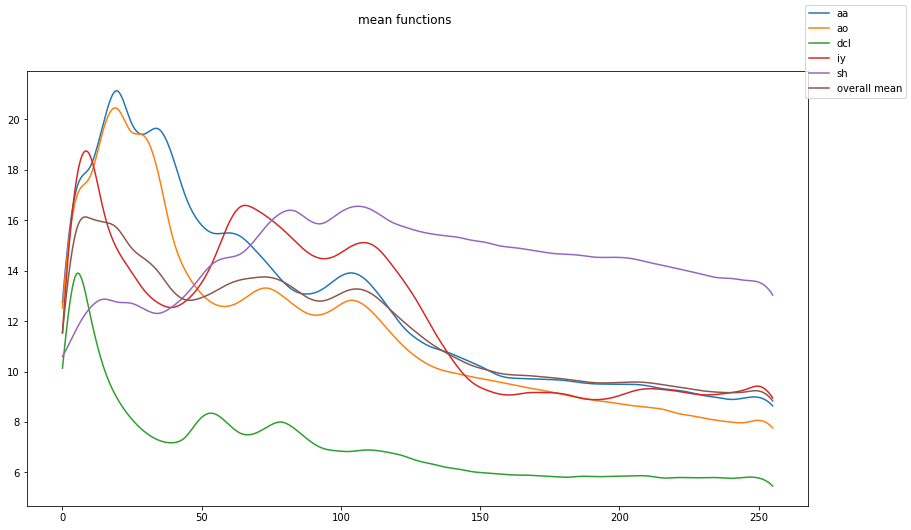

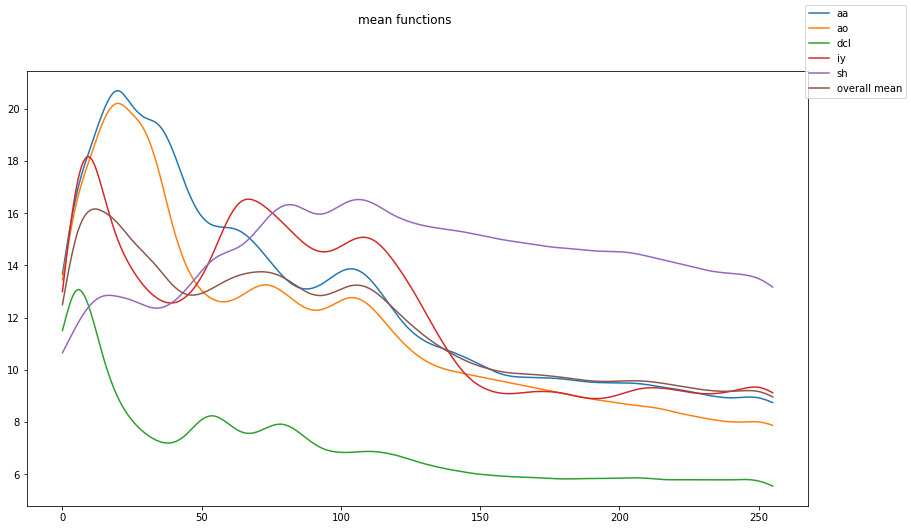

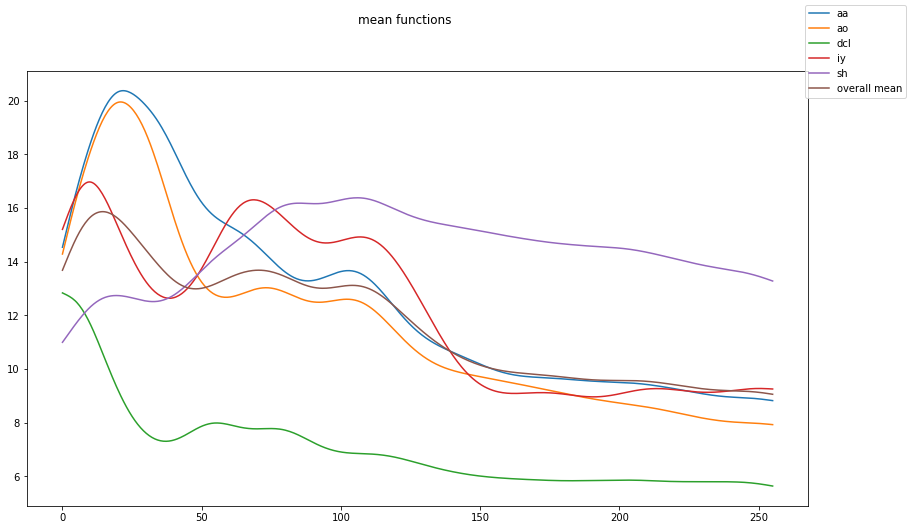

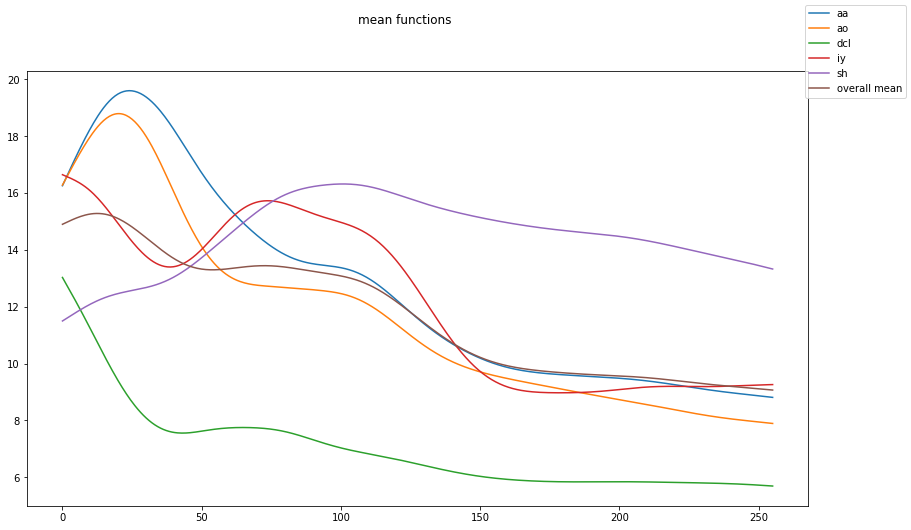

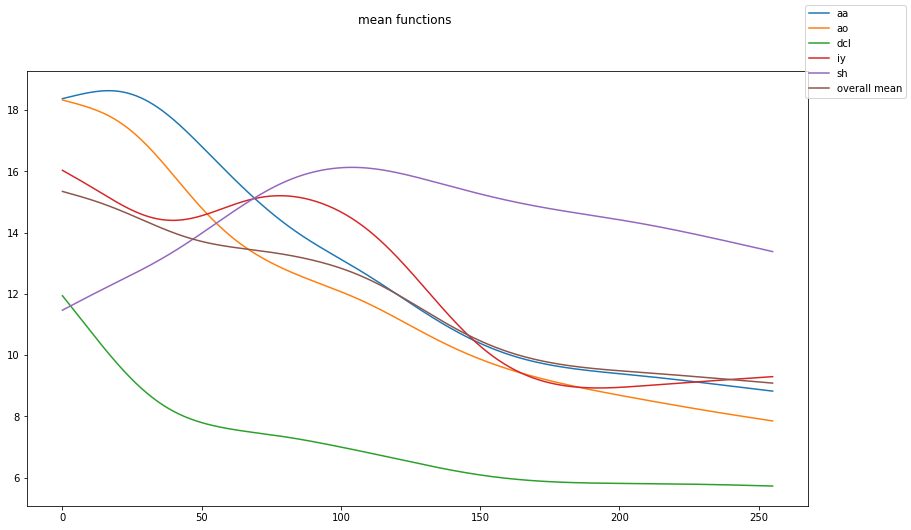

In [189]:
for i in range(6):
    plot_means_with_overall(smoothed_datasets[i], names)

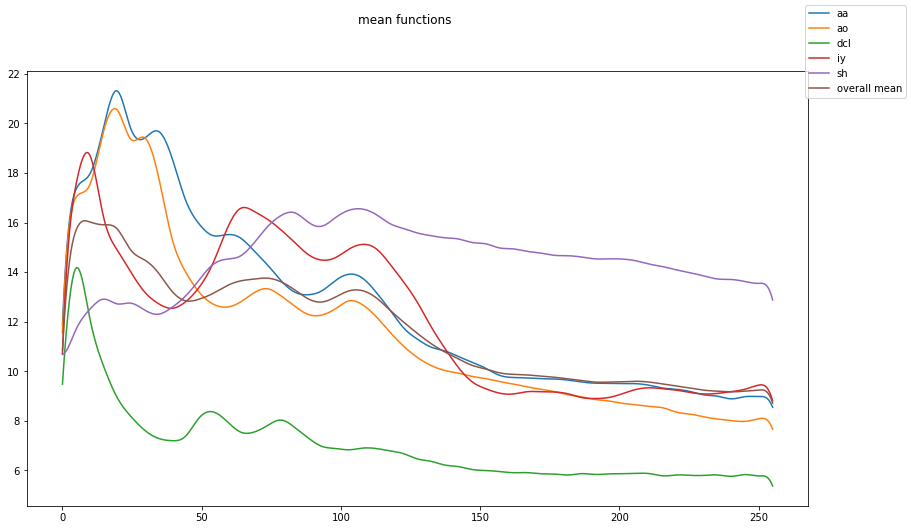

In [184]:
means_0 = get_mean_functions(smoothed_datasets[0], names)
means_0.append(smoothed_datasets[0].mean())
plot_same_fig(means_0, names + ['overall mean'], 6, 'mean functions')

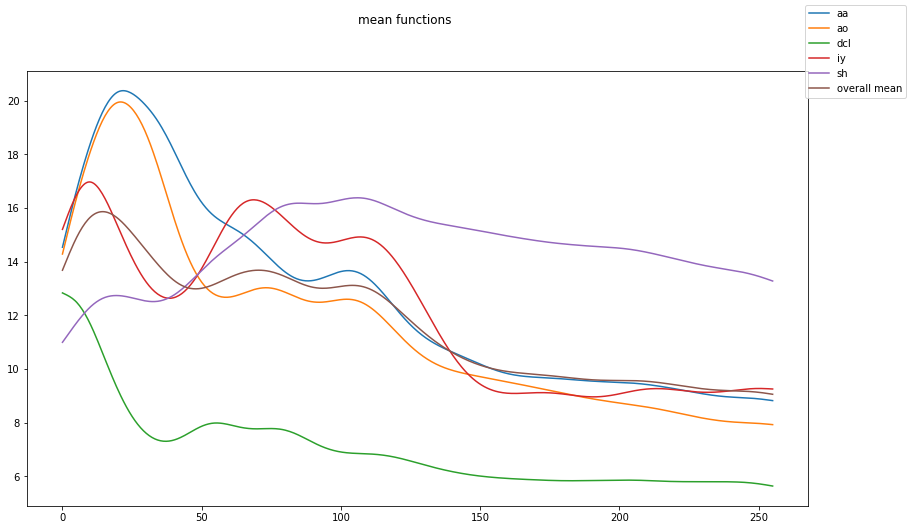

In [187]:
means_5 = get_mean_functions(smoothed_datasets[3], names)
means_5.append(smoothed_datasets[3].mean())
plot_same_fig(means_5, names + ['overall mean'], 6, 'mean functions')

# Phonemes

In [53]:
phonemes = fetch_phoneme()
fd_data = phonemes['data']

In [39]:
phonemes['target']


array([4, 3, 2, ..., 4, 1, 1], dtype=int8)

In [40]:
phonemes['target_names']

['aa', 'ao', 'dcl', 'iy', 'sh']

In [46]:
phonemes['target'][5:10]

array([3, 0, 4, 1, 1], dtype=int8)

In [55]:
fd = fd_data
param_values = np.linspace(start=2, stop=25, num=24)

llr = val.SmoothingParameterSearch(
    ks.LocalLinearRegressionSmoother(), param_values)
llr.fit(fd)
llr_fd = llr.transform(fd)

In [49]:
y = phonemes['target']


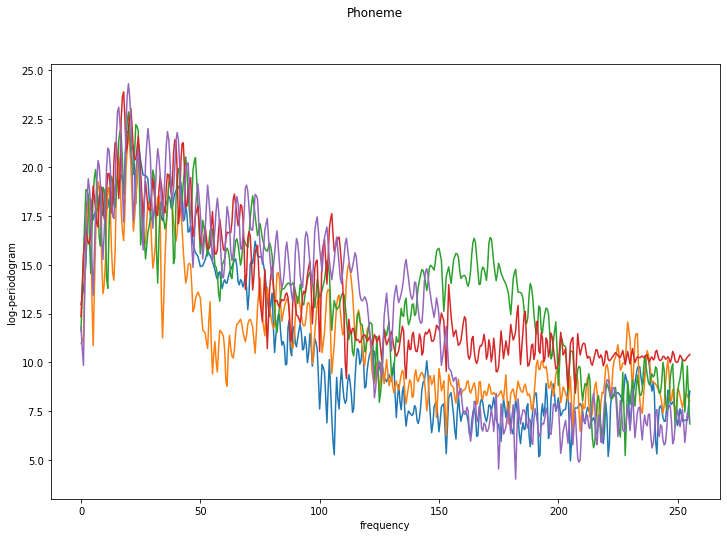

In [50]:
fd_data[y==0][:5].plot()
pyplot.show()


### Phonemes smoothed, discrete representation

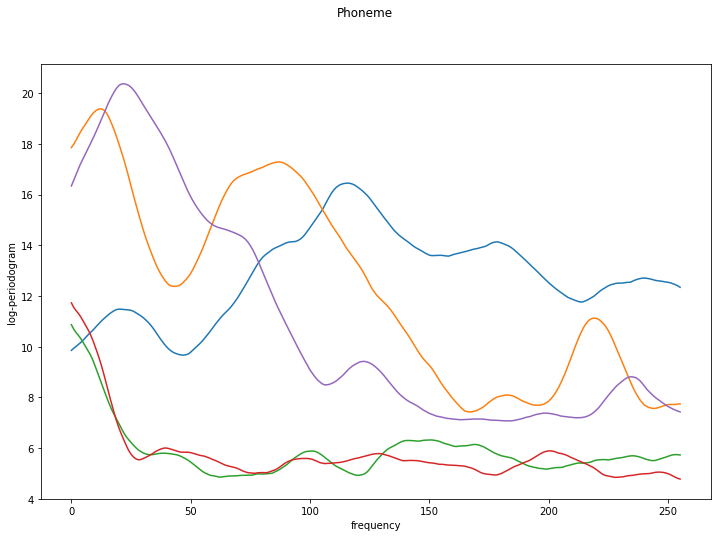

In [150]:
llr_fd[:5].plot()
pyplot.show()

In [151]:
llr_fd_basis = llr_fd.to_basis(BSpline(n_basis=20))

### Phonemes smoothed, basis representation

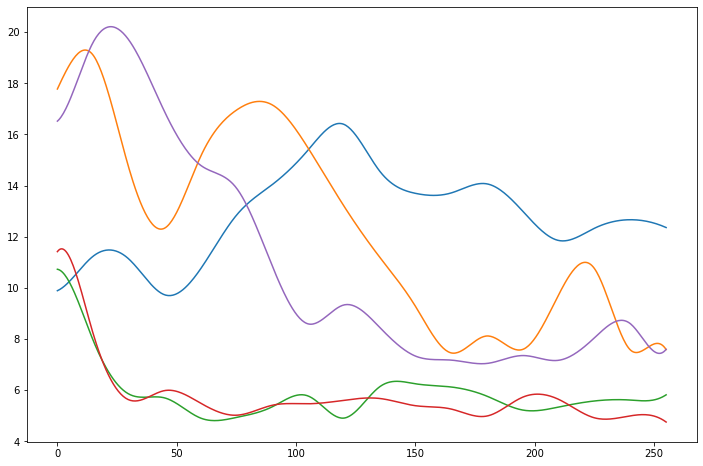

In [152]:
llr_fd_basis[:5].plot()
pyplot.show()

### Phonemes without smoothing, basis representation

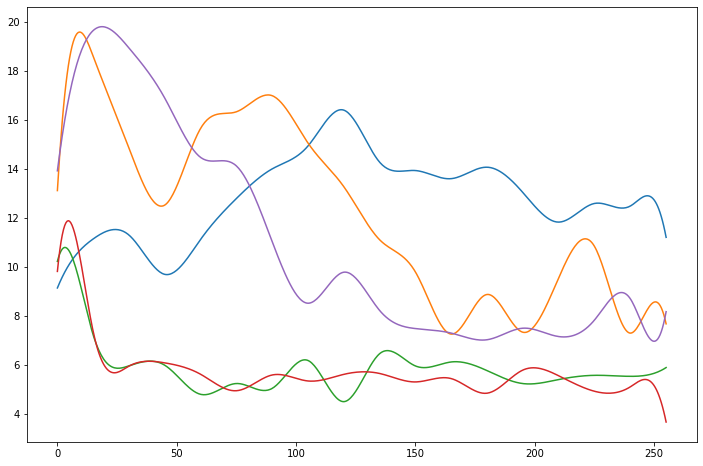

In [58]:
fd_basis = fd.to_basis(BSpline(n_basis=20))
fd_basis[:5].plot()
pyplot.show()

### Phonemes principal components without smoothing or regularization

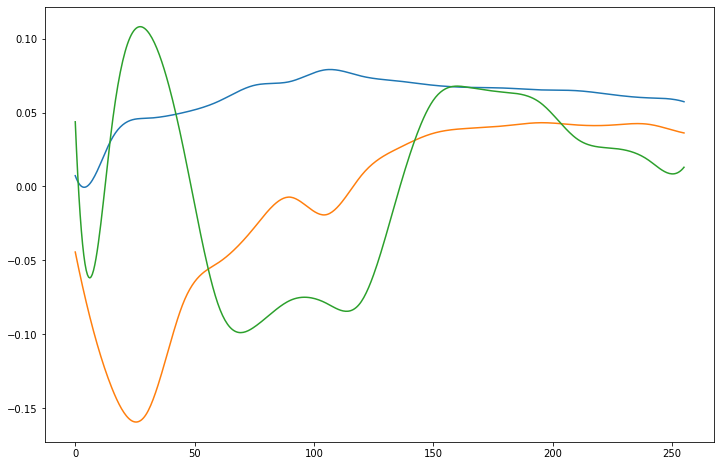

In [154]:
fpca = FPCABasis()
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### Phonemes principal components with smoothing

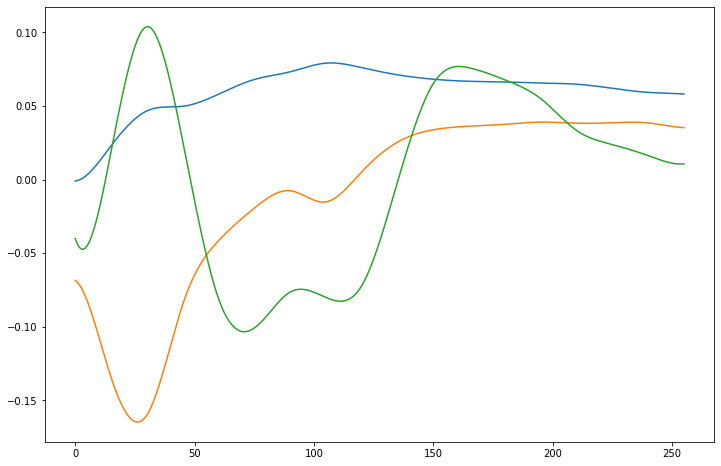

In [155]:
fpca.fit(llr_fd_basis.copy())
fpca.components.plot()
pyplot.show()

### Phonemes principal components with regularization, lambda=10000

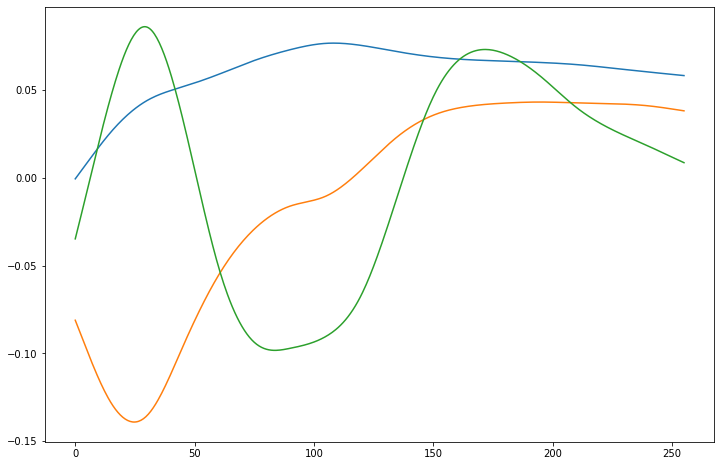

In [156]:
fpca = FPCABasis(regularization_parameter=1e4)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### Phonemes principal components with regularization, lambda=1000

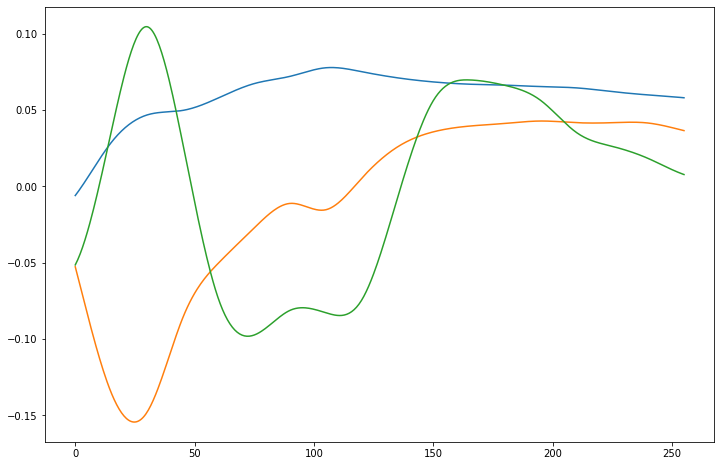

In [157]:
fpca = FPCABasis(regularization_parameter=1e3)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### Phonemes principal components with regularization, lambda=100

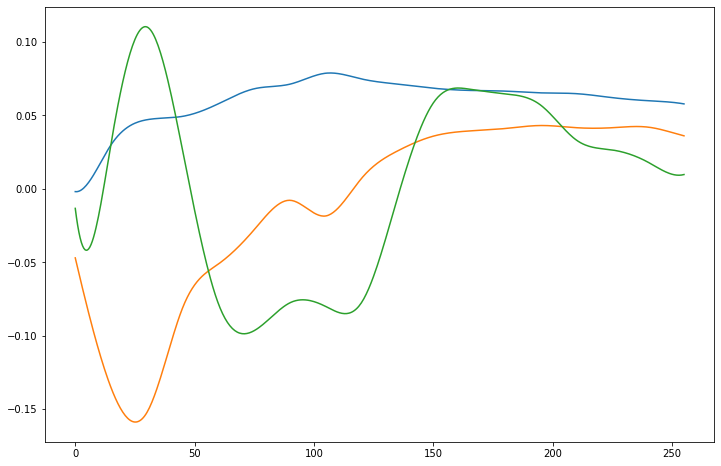

In [158]:
fpca = FPCABasis(regularization_parameter=1e2)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### Phonemes principal components with regularization, lambda=10

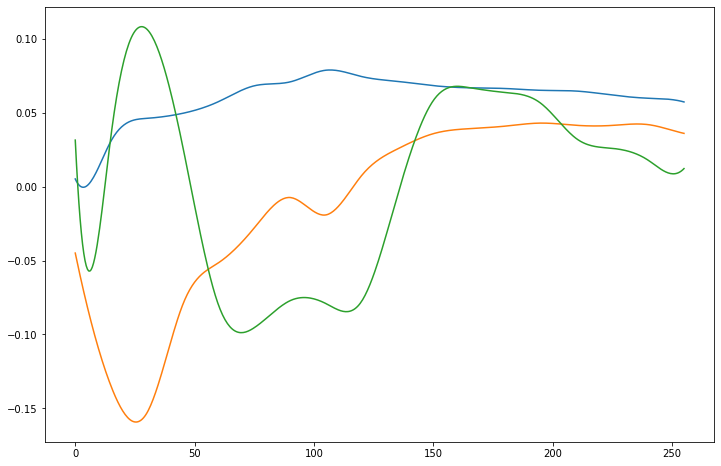

In [159]:
fpca = FPCABasis(regularization_parameter=1e1)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### Phonemes principal components with regularization, lambda=1

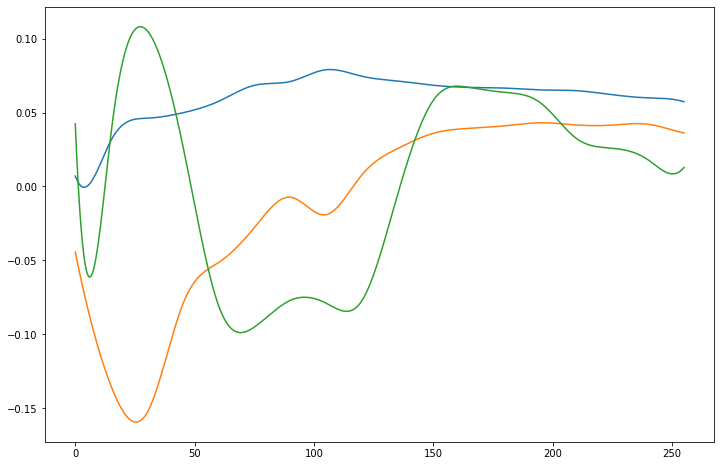

In [160]:
fpca = FPCABasis(regularization_parameter=1)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### Phonemes principal components with regularization, lambda=0.1

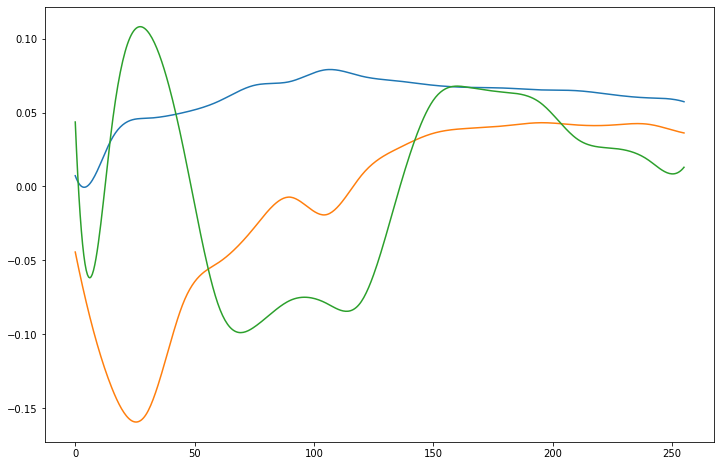

In [162]:
fpca = FPCABasis(regularization_parameter=0.1)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

In [106]:
finder2 = RegularizationParameterSearch(estimator=FPCABasis(regularization_derivative_degree=2),
                                       param_values=[0.1, 1, 1e1, 1e2, 1e3, 1e4],
                                       scoring=FPCARegularizationCVScorer(),
                                       verbose=True,
                                       n_jobs=12)

finder2.fit(fd_basis)

Fitting 50 folds for each of 6 candidates, totalling 300 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

# medflies

In [18]:
fd = fetch_medflies()['data']
param_values = np.linspace(start=1, stop=25, num=25)

# Local linear regression kernel smoothing.
llr = val.SmoothingParameterSearch(
    ks.LocalLinearRegressionSmoother(), param_values)
llr.fit(fd)
llr_fd = llr.transform(fd)
n_basis = 15

In [33]:
fd.n_samples

534

In [19]:
llr.cv_results_['mean_test_score']

array([-26593.80583721,  -1337.07444349,   -620.32744386,   -447.0843736 ,
         -379.52967041,   -349.40486222,   -336.21294871,   -331.33906997,
         -330.55712491,   -331.70208578,   -333.67393193,   -335.9252737 ,
         -338.19032956,   -340.34550951,   -342.33898842,   -344.15507669,
         -345.79597104,   -347.2722818 ,   -348.59808155,   -349.78833211,
         -350.8575835 ,   -351.81935951,   -352.68591348,   -353.46818091,
         -354.17583231])

### Medflies, first 5 samples

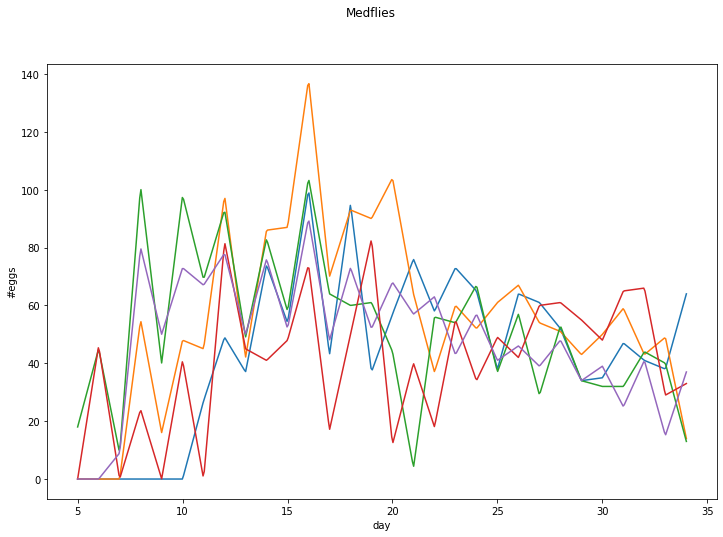

In [20]:
fd[:5].plot()
pyplot.show()

### Medflies, first 5 samples, basis representation

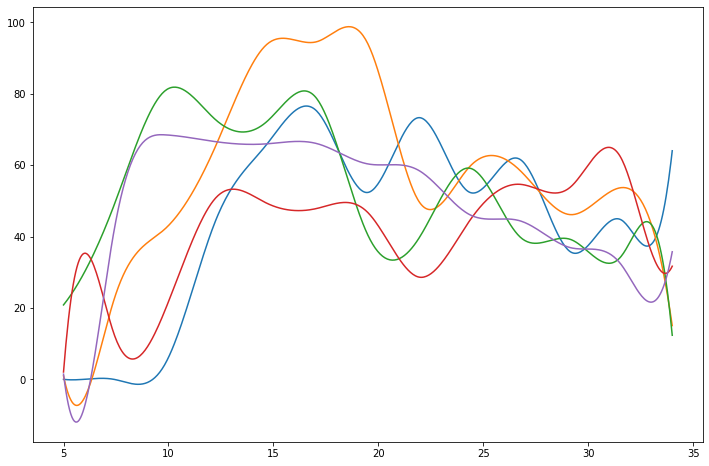

In [21]:
fd_basis = fd.to_basis(BSpline(n_basis=n_basis))
fd_basis[:5].plot()
pyplot.show()

### Medflies, first 5 samples smoothed, discrete representation

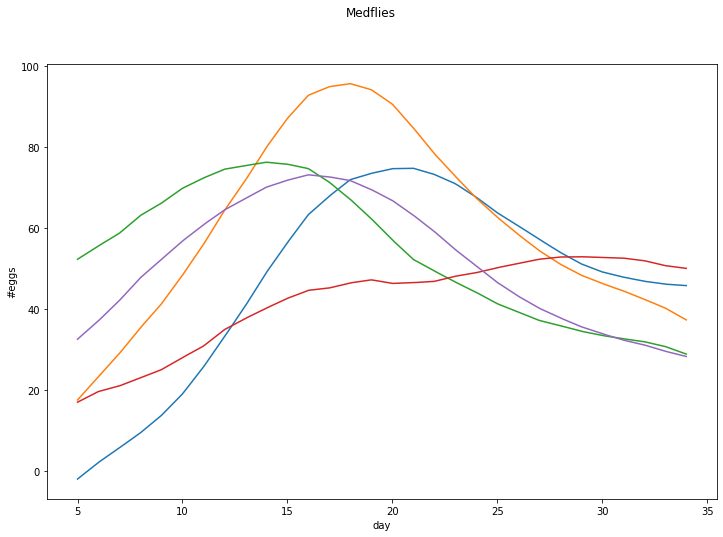

In [22]:
llr_fd[:5].plot()
pyplot.show()

In [23]:
llr_fd_basis = llr_fd.to_basis(BSpline(n_basis=n_basis))

### Medflies, first 5 samples smoothed, basis representation

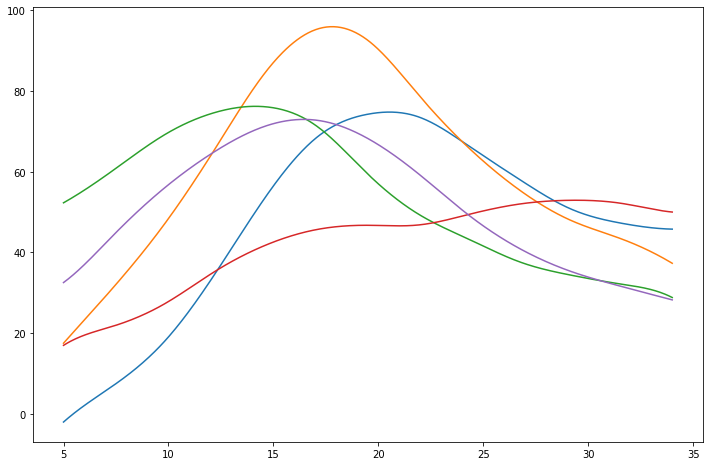

In [24]:
llr_fd_basis[:5].plot()
pyplot.show()

### principal components without smoothing or regularization

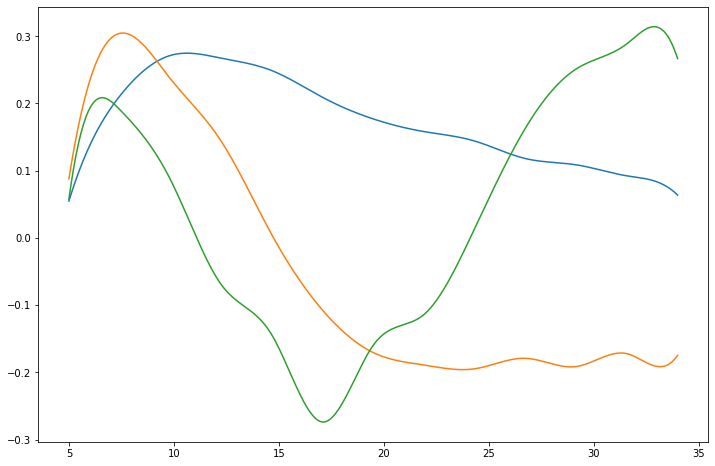

In [25]:
fpca = FPCABasis()
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### principal components with smoothed data

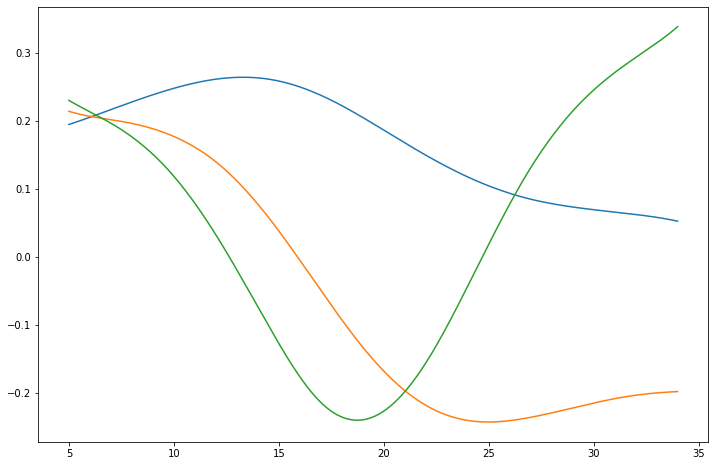

In [26]:
fpca.fit(llr_fd_basis.copy())
fpca.components.plot()
pyplot.show()

### principal components with regularization on unsmoothed data, lambda=100

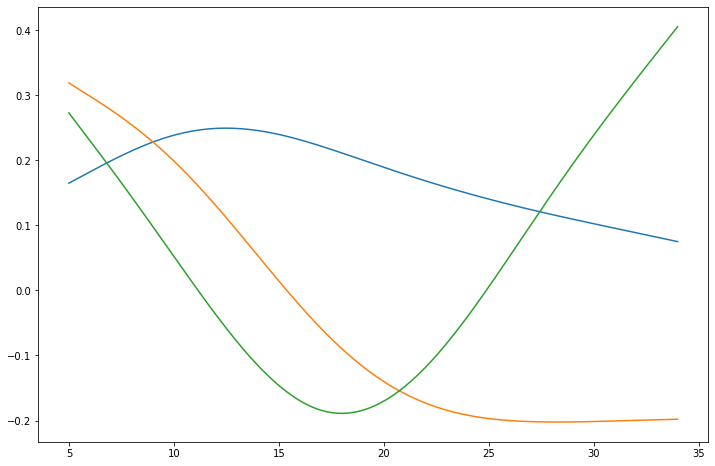

In [27]:
fpca = FPCABasis(regularization_parameter=100)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### principal components with regularization on unsmoothed data, lambda=10

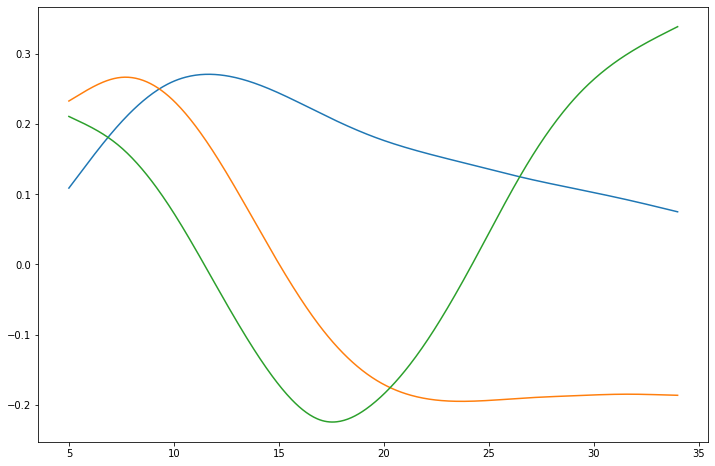

In [28]:
fpca = FPCABasis(regularization_parameter=10)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### principal components with regularization on unsmoothed data, lambda=1

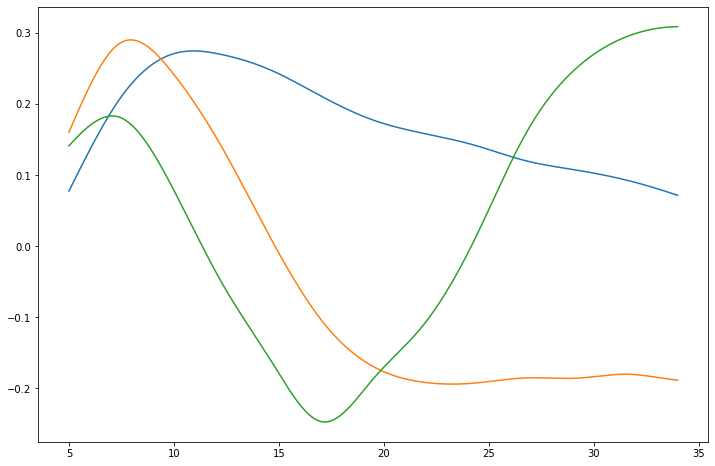

In [29]:
fpca = FPCABasis(regularization_parameter=1)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### principal components with regularization on unsmoothed data, lambda=0.1

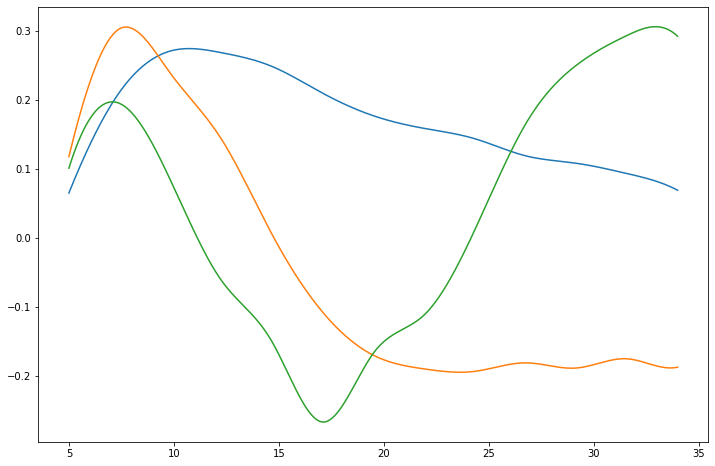

In [30]:
fpca = FPCABasis(regularization_parameter=0.1)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### principal components with regularization on unsmoothed data, lambda=0.01

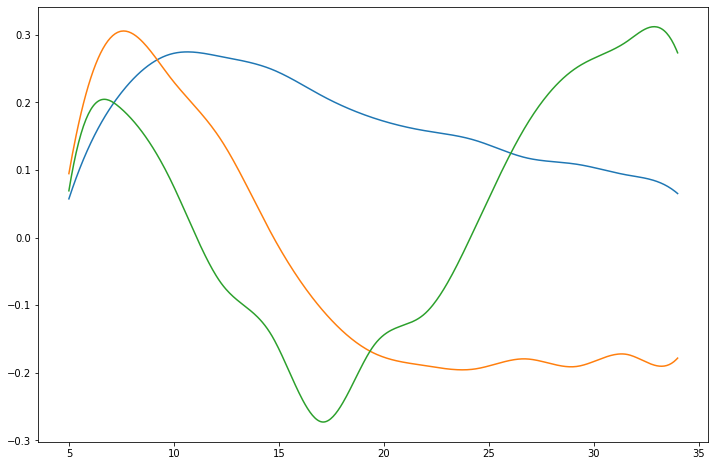

In [31]:
fpca = FPCABasis(regularization_parameter=0.01)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

### principal components without smoothing or regularization

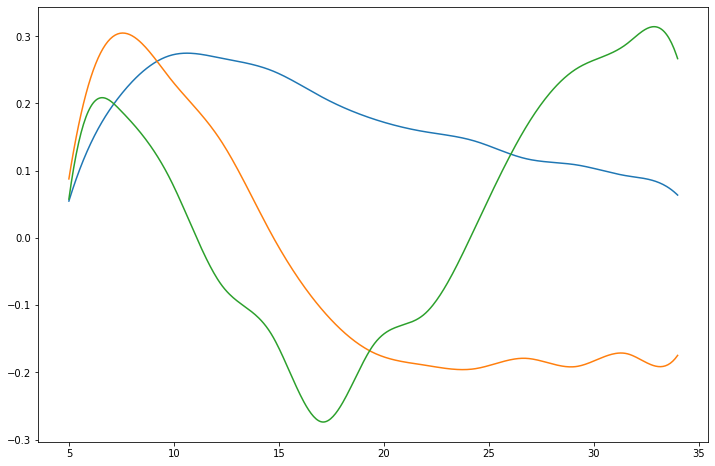

In [32]:
fpca = FPCABasis()
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

# medflies 50 values

In [120]:
fd = fetch_medflies()['data'][:50]
param_values = np.linspace(start=2, stop=25, num=24)

# Local linear regression kernel smoothing.
llr = val.SmoothingParameterSearch(
    ks.LocalLinearRegressionSmoother(), param_values)
llr.fit(fd)
llr_fd = llr.transform(fd)
n_basis = 10

In [93]:
param_values

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.])

In [92]:
llr.cv_results_['mean_test_score']

array([-1783.17381026,  -812.70171715,  -572.80443959,  -475.79726081,
        -430.35215022,  -408.67017358,  -398.93544386,  -395.45181985,
        -395.24732219,  -396.70158182,  -398.92556488,  -401.43726225,
        -403.98107993,  -406.42677839,  -408.71321067,  -410.81701175,
        -412.73511222,  -414.47493742,  -416.04891408,  -417.47141289,
        -418.757079  ,  -419.91995623,  -420.97306446,  -421.92823344])

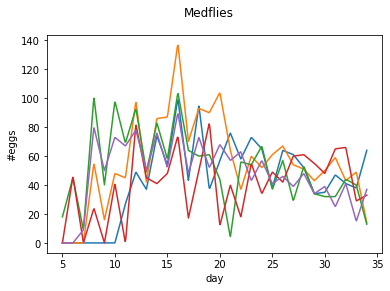

In [78]:
fd[:5].plot()
pyplot.show()

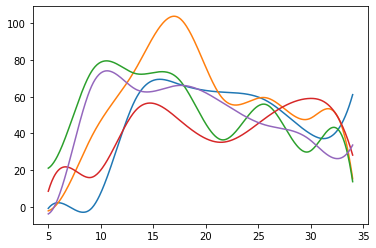

In [121]:
fd_basis = fd.to_basis(BSpline(n_basis=n_basis))
fd_basis[:5].plot()
pyplot.show()

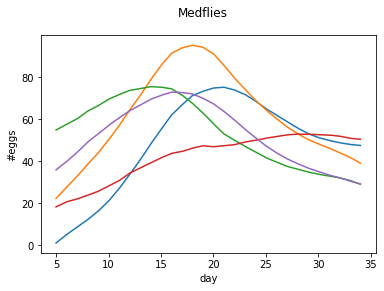

In [80]:
llr_fd[:5].plot()
pyplot.show()

In [122]:
llr_fd_basis = llr_fd.to_basis(BSpline(n_basis=n_basis))

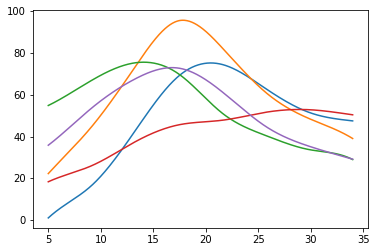

In [82]:
llr_fd_basis[:5].plot()
pyplot.show()

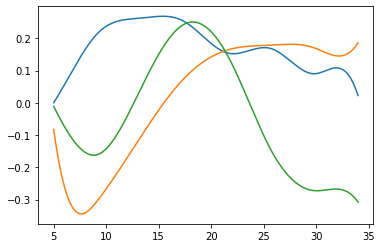

In [83]:
fpca = FPCABasis()
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

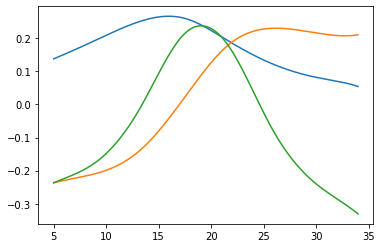

In [84]:
fpca.fit(llr_fd_basis.copy())
fpca.components.plot()
pyplot.show()

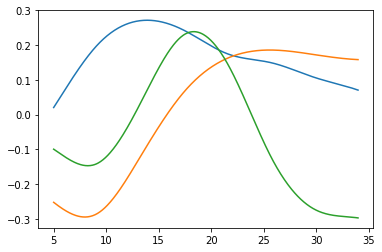

In [123]:
fpca = FPCABasis(regularization_parameter=10)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

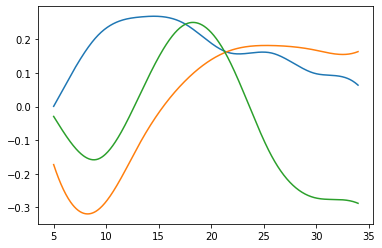

In [95]:
fpca = FPCABasis(regularization_parameter=1)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

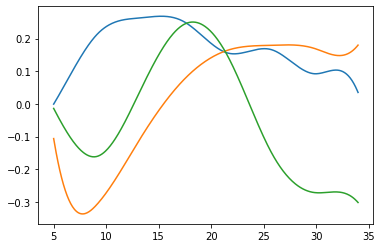

In [90]:
fpca = FPCABasis(regularization_parameter=0.1)
fpca.fit(fd_basis.copy())
fpca.components.plot()
pyplot.show()

In [88]:
finder1 = RegularizationParameterSearch(estimator=FPCABasis(regularization_derivative_degree=2),
                                       param_values=[0.1, 1, 1e1, 1e2, 1e3, 1e4],
                                       scoring=FPCARegularizationCVScorer(),
                                       verbose=True,
                                       n_jobs=12)

finder1.fit(fd_basis)

Fitting 50 folds for each of 6 candidates, totalling 300 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   43.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  5.6min finished


RegularizationParameterSearch(estimator=FPCABasis(centering=True,
                                                  components_basis=None,
                                                  n_components=10,
                                                  regularization_coefficients=None,
                                                  regularization_derivative_degree=2,
                                                  regularization_parameter=0),
                              n_jobs=12, param_values=None,
                              scoring=<skfda.preprocessing.dim_reduction.projection._regularization_param_search.FPCARegularizationCVScorer object at 0x7fded06701d0>,
                              verbose=True)

In [89]:
finder1.cv_results_['mean_test_score']

array([ -9211.67046036,  -9464.01490904, -10067.14947621, -10951.44024594,
       -12108.36994064, -13033.47450215])